<div style="text-align: right;">
-kngbq
</div>


In [ ]:
import os
import json
import subprocess
import time
from mininet.net import Mininet
from mininet.topo import Topo
from mininet.node import Switch
from mininet.cli import CLI
from mininet.log import setLogLevel, info

# Custom BMv2 P4 switch
class P4Switch(Switch):
    def __init__(self, name, json_file, thrift_port=9090, **params):
        Switch.__init__(self, name, **params)
        self.json_file = json_file
        self.thrift_port = thrift_port

    def start(self, controllers):
        cmd = f"simple_switch --thrift-port {self.thrift_port} --log-console {self.json_file} &"
        info(f"*** Starting P4 switch {self.name}: {cmd}\n")
        os.system(cmd)
        time.sleep(2)  # Wait for the switch to start

    def stop(self):
        info(f"*** Stopping P4 switch {self.name}\n")
        os.system("pkill simple_switch")

# Mininet topology (h1 ↔ s1 ↔ h2)
class NetworkTopo(Topo):
    def __init__(self, json_file):
        Topo.__init__(self)

        s1 = self.addSwitch('s1', cls=P4Switch, json_file=json_file, thrift_port=9090)
        h1 = self.addHost('h1', ip='10.0.1.1/24', mac='00:00:00:00:01:01')
        h2 = self.addHost('h2', ip='10.0.1.2/24', mac='00:00:00:00:01:02')

        self.addLink(h1, s1)
        self.addLink(h2, s1)

def compile_p4():
    print("Compiling P4 program...")
    result = subprocess.run(
        ['p4c', '--target', 'bmv2', '--arch', 'v1model', '-o', '.', 'forward.p4'], 
        capture_output=True, text=True
    )

    if result.returncode != 0:
        print("P4 compilation failed!")
        print(f"Error: {result.stderr}")
        exit(1)
    else:
        print("P4 compilation successful")

def validate_json():
    try:
        with open('forward.json', 'r') as f:
            json.load(f)
        print("JSON output is valid")
    except (json.JSONDecodeError, FileNotFoundError) as e:
        print(f"Error with JSON output: {e}")
        exit(1)

def start_network():
    json_file = "forward.json"  
    net = Mininet(topo=NetworkTopo(json_file), controller=None)
    
    net.start()
    
    # Configure multicast flooding and table entries
    s1 = net.get('s1')
    s1.cmd('simple_switch_CLI --thrift-port 9090 << EOF\n'
           # Multicast group configuration
           'mc_mgrp_create 1\n'
           'mc_node_create 0 0 1\n'  # Ports 0 and 1
           'mc_node_associate 1 0\n'
           
           # Ethernet table entries
           'table_add ethernet_exact forward 00:00:00:00:01:01 => 0\n'
           'table_add ethernet_exact forward 00:00:00:00:01:02 => 1\n'
           
           # IPv4 table entries
           'table_add ipv4_lpm forward 10.0.1.1/32 => 0\n'
           'table_add ipv4_lpm forward 10.0.1.2/32 => 1\n'
           'EOF')
    
    # Configure hosts
    h1, h2 = net.get('h1', 'h2')
    
    # Populate ARP tables
    h1.cmd('arp -s 10.0.1.2 00:00:00:00:01:02')
    h2.cmd('arp -s 10.0.1.1 00:00:00:00:01:01')
    
    print("*** Running ping test ***")
    net.pingAll()
    
    CLI(net)
    net.stop()

if __name__ == '__main__':
    setLogLevel('info')

    # Clean up before running
    os.system('sudo pkill -f simple_switch')
    os.system('sudo rm -f *.log *.txt')

    # Verify installations
    for tool in ['p4c', 'simple_switch']:
        if subprocess.run(['which', tool], capture_output=True).returncode != 0:
            print(f"ERROR: {tool} not found in PATH!")
            exit(1)

    compile_p4()      # Compile P4 file
    validate_json()   # Ensure JSON is valid
    start_network()   # Start Mininet

In [ ]:
# !pip install p4runtime

#!pip list
#!pip install ryu

In [ ]:
import sys
import os

# Remove duplicate paths
sys.path = list(set(sys.path))

# Check if the executables are available
os.system('simple_switch --version')
os.system('p4c --version')
os.system('ryu --version')
os.system("ryu-manager ryu.app.simple_switch_13")


In [ ]:
import sys
print(sys.executable)


In [ ]:
from mininet.net import Mininet
from mininet.topo import Topo
from mininet.node import Host
from mininet.link import TCLink

class SimpleTopo(Topo):
    def __init__(self):
        Topo.__init__(self)
        
        # Add 3 switches
        s1 = self.addSwitch('s1', cls=None, cmd='simple_switch --interface 0@veth0 --log-console basic_forward.json')
        s2 = self.addSwitch('s2', cls=None, cmd='simple_switch --interface 0@veth2 --log-console basic_forward.json')
        s3 = self.addSwitch('s3', cls=None, cmd='simple_switch --interface 0@veth4 --log-console basic_forward.json')
        
        # Add 3 hosts
        h1 = self.addHost('h1', ip='10.0.1.1/24')
        h2 = self.addHost('h2', ip='10.0.1.2/24')
        h3 = self.addHost('h3', ip='10.0.1.3/24')
        
        # Connect hosts to switches
        self.addLink(h1, s1)
        self.addLink(h2, s2)
        self.addLink(h3, s3)
        
        # Connect switches in a line: s1 <-> s2 <-> s3
        self.addLink(s1, s2)
        self.addLink(s2, s3)

# Create network
net = Mininet(topo=SimpleTopo(), controller=None)
net.start()

# Open Mininet CLI for manual control (optional)
net.interact()

In [ ]:
##### P4 program behavior in all 3 switches

In [ ]:
from mininet.net import Mininet
from mininet.topo import Topo
import os

class SimpleTopo(Topo):
    def __init__(self):
        Topo.__init__(self)
        
        # Get absolute path to JSON file
        json_path = os.path.abspath("basic_forward.json")
        
        # Add switches with explicit Thrift ports
        s1 = self.addSwitch('s1', cls=None, cmd='/usr/local/bin/simple_switch --thrift-port 9090 --log-console %s' % json_path)
        s2 = self.addSwitch('s2', cls=None, cmd=f'simple_switch --thrift-port 9091 --log-console {json_path}')
        s3 = self.addSwitch('s3', cls=None, cmd=f'simple_switch --thrift-port 9092 --log-console {json_path}')
        
        # Add hosts
        h1 = self.addHost('h1', ip='10.0.1.1/24')
        h2 = self.addHost('h2', ip='10.0.1.2/24')
        h3 = self.addHost('h3', ip='10.0.1.3/24')
        
        # Connect hosts to switches
        self.addLink(h1, s1)
        self.addLink(h2, s2)
        self.addLink(h3, s3)
        
        # Connect switches in a line
        self.addLink(s1, s2)
        self.addLink(s2, s3)

# Start the network
net = Mininet(topo=SimpleTopo(), controller=None)
net.start()
net.interact()  # Keep the network running

In [ ]:
from mininet.net import Mininet
from mininet.topo import Topo
import os
from mininet.node import Controller, OVSController, OVSSwitch
from mininet.cli import CLI
from mininet.link import TCLink

class SimpleTopo(Topo):
    def __init__(self):
        Topo.__init__(self)

        # Get absolute path to JSON file
        json_path = os.path.abspath("basic_forward.json")

        # Add switches
        s1 = self.addSwitch('s1', cls=OVSSwitch)
        s2 = self.addSwitch('s2', cls=OVSSwitch)  # Default OVS switch
        s3 = self.addSwitch('s3', cls=OVSSwitch)  # Default OVS switch

        # Add hosts
        h1 = self.addHost('h1', ip='10.0.1.1/24')
        h2 = self.addHost('h2', ip='10.0.1.2/24')
        h3 = self.addHost('h3', ip='10.0.1.3/24')

        # Connect hosts to switches
        self.addLink(h1, s1)
        self.addLink(h2, s2)
        self.addLink(h3, s3)

        # Connect switches in a line
        self.addLink(s1, s2)
        self.addLink(s2, s3)

# Start the network with an OVS controller
net = Mininet(topo=SimpleTopo(), controller=OVSController)
net.start()

# Attach the OVS controller to s2 and s3
net.get('s2').start([net.controllers[0]])
net.get('s3').start([net.controllers[0]])

# Run the CLI for debugging
CLI(net)

# Stop the network after exiting CLI
net.stop()


In [ ]:
from mininet.net import Mininet
from mininet.topo import Topo
from mininet.node import RemoteController, OVSSwitch, Host, Switch
from mininet.cli import CLI
from mininet.log import setLogLevel, info
import os

class P4Switch(Switch):
    def __init__(self, name, json_file, thrift_port=9090, **params):
        Switch.__init__(self, name, **params)
        self.json_file = json_file
        self.thrift_port = thrift_port

    def start(self, controllers):
        cmd = f"simple_switch --thrift-port {self.thrift_port} --log-console {self.json_file} &"
        info(f"*** Starting P4 switch {self.name}: {cmd}\n")
        os.system(cmd)

    def stop(self):
        info(f"*** Stopping P4 switch {self.name}\n")
        os.system("pkill simple_switch")

class HybridTopo(Topo):
    def __init__(self, json_file):
        Topo.__init__(self)

        s1 = self.addSwitch('s1', cls=P4Switch, json_file=json_file, thrift_port=9090)
        s2 = self.addSwitch('s2', cls=OVSSwitch)
        s3 = self.addSwitch('s3', cls=OVSSwitch)

        h1 = self.addHost('h1', ip='10.0.1.1/24')
        h2 = self.addHost('h2', ip='10.0.2.1/24')
        h3 = self.addHost('h3', ip='10.0.3.1/24')

        self.addLink(h1, s1)
        self.addLink(h2, s2)
        self.addLink(h3, s3)

        self.addLink(s1, s2)
        self.addLink(s1, s3)

def start_mininet():
    json_file = "basic_forward.json"  # Ensure this file exists
    net = Mininet(topo=HybridTopo(json_file), controller=None)
    net.addController('c0', controller=RemoteController, ip='127.0.0.1', port=6633)

    net.start()
    CLI(net)  # Open CLI within the notebook
    net.stop()

setLogLevel('info')
start_mininet()


### WITH RYU

In [ ]:
import os
from mininet.net import Mininet
from mininet.topo import Topo
from mininet.node import RemoteController, OVSSwitch
from mininet.cli import CLI
from mininet.log import setLogLevel, info
import subprocess

class SimpleSwitch(OVSSwitch):
    def __init__(self, name, **params):
        OVSSwitch.__init__(self, name, **params)

class HybridTopo(Topo):
    def __init__(self):
        Topo.__init__(self)

        # Simple switch (s1)
        s1 = self.addSwitch('s1', cls=SimpleSwitch)

        # OVS switches (s2, s3) - OpenFlow switches
        s2 = self.addSwitch('s2', cls=OVSSwitch)
        s3 = self.addSwitch('s3', cls=OVSSwitch)

        # Hosts
        h1 = self.addHost('h1', ip='10.0.1.1/24')
        h2 = self.addHost('h2', ip='10.0.2.1/24')
        h3 = self.addHost('h3', ip='10.0.3.1/24')

        # Connect hosts to their respective switches
        self.addLink(h1, s1)
        self.addLink(h2, s2)
        self.addLink(h3, s3)

        # Connect the switches together
        self.addLink(s1, s2)
        self.addLink(s1, s3)

def start_mininet():

    print("Starting Ryu controller...")
    ryu_process = subprocess.Popen(['ryu-manager', 'ryu.app.simple_switch_13'])
    
    # Start Mininet with the HybridTopo, and use Ryu controller (RemoteController)
    net = Mininet(topo=HybridTopo(), controller=None)

    # Start Ryu controller using subprocess (ensure Ryu is running before Mininet)
    

    # Add OpenFlow controller for s2 and s3
    net.addController('c0', controller=RemoteController, ip='127.0.0.1', port=6633)

    # Start the Mininet network
    net.start()

    # Assign the OpenFlow controller to OVS switches (s2 and s3)
    os.system("sudo ovs-vsctl set-controller s2 tcp:127.0.0.1:6633")
    os.system("sudo ovs-vsctl set-controller s3 tcp:127.0.0.1:6633")

    print("\nNetwork is running! Use the Mininet CLI.")
    CLI(net)

    # Stop Mininet and Ryu controller process after the test
    net.stop()
    ryu_process.terminate()

if __name__ == '__main__':
    setLogLevel('info')
    start_mininet()


In [ ]:
# !pip uninstall eventlet -y
# !pip install eventlet==0.33.1
# !pip install pyyaml netaddr dnspython


In [ ]:
import eventlet
import dns
print(eventlet.__version__)
print(dns.__version__)


In [ ]:
%%writefile drop_all.p4
#include <core.p4>
#include <v1model.p4>

struct metadata { /* empty */ }

parser MyParser(packet_in packet,
                out headers hdr,
                inout metadata meta,
                inout standard_metadata_t standard_metadata) {
    state start { transition accept; }
}

control MyIngress(inout headers hdr,
                  inout metadata meta,
                  inout standard_metadata_t standard_metadata) {
    apply {
        standard_metadata.egress_spec = 0; // Drop all packets
    }
}

control MyEgress(inout headers hdr,
                 inout metadata meta,
                 inout standard_metadata_t standard_metadata) {
    apply { }
}

control MyDeparser(packet_out packet, in headers hdr) {
    apply { packet.emit(hdr); }
}

V1Switch(MyParser(), MyIngress(), MyEgress(), MyDeparser()) main;

In [ ]:
from mininet.topo import Topo
from mininet.net import Mininet
from mininet.node import OVSSwitch
from mininet.cli import CLI
from mininet.log import setLogLevel
import subprocess
import time

class P4Switch(OVSSwitch):
    def __init__(self, name, **params):
        super().__init__(name, **params)
        self.sw_path = params.get('sw_path', '/usr/local/bin/simple_switch')
        self.json_path = params.get('json_path', '')
        
    def start(self, controllers):
        # Map BMv2 ports 0 ↔ h1, 1 ↔ s2
        self.cmd(f'{self.sw_path} --log-console \
                -i 0@h1-s1 -i 1@s1-s2 {self.json_path} > /dev/null 2>&1 &')
        time.sleep(10)  # Increase sleep for switch initialization

class NetworkTopo(Topo):
    def build(self):
        # Hosts (Same Subnet)
        h1 = self.addHost('h1', ip='10.0.2.1/24')
        h2 = self.addHost('h2', ip='10.0.2.2/24')
        h3 = self.addHost('h3', ip='10.0.2.3/24')

        # Switches
        s1 = self.addSwitch('s1', cls=P4Switch,
                          sw_path='/usr/local/bin/simple_switch',
                          json_path='basic_forward.json')
        s2 = self.addSwitch('s2', cls=OVSSwitch)
        s3 = self.addSwitch('s3', cls=OVSSwitch)

        # Links with explicit interface names
        self.addLink(h1, s1, intfName1='h1-eth0', intfName2='s1-eth0')
        self.addLink(s1, s2, intfName1='s1-eth1', intfName2='s2-eth0')
        self.addLink(s2, s3)
        self.addLink(s3, h2)
        self.addLink(s3, h3)

if __name__ == '__main__':
    setLogLevel('info')
    
    # Compile P4 program
    subprocess.run(['p4c-bm2-ss', '-o', 'basic_forward.json', 'basic_forward.p4'], check=True)
    
    # Start network
    net = Mininet(topo=NetworkTopo(), controller=None)
    net.start()
    # After net.start()
    net['h1'].cmd('arp -s 10.0.2.2 00:00:00:00:00:02')
    net['h2'].cmd('arp -s 10.0.2.1 00:00:00:00:00:01')
    # Configure OVS switches
    for sw in ['s2', 's3']:
        net[sw].cmd('ovs-ofctl add-flow %s "actions=flood"' % sw)
    
    # Add static ARP entries
    net['h1'].cmd('arp -s 10.0.2.2 00:00:00:00:00:02')
    net['h2'].cmd('arp -s 10.0.2.1 00:00:00:00:00:01')
    
    # Configure P4 switch
    s1 = net['s1']
    # In Jupyter notebook, after starting the network:
    s1.cmd('simple_switch_CLI << EOF\n'
           'mc_mgrp_create 1\n'                # Create multicast group 1
           'mc_node_create 0 0 1 2\n'          # Node 0: ports 0 (h1), 1 (s2), 2 (control)
           'mc_node_associate 1 0\n'            # Associate group 1 with node 0
           'table_add dmac forward 00:00:00:00:00:01 => 0\n'  # h1 → port 0
           'table_add dmac forward 00:00:00:00:00:02 => 1\n'  # h2 → port 1
           'EOF')
    
    # Test connectivity
    print("\n=== Final Connectivity Test ===")
    print("h1 -> h2:", net['h1'].cmd('ping -c 4 10.0.2.2'))
    print("h2 -> h1:", net['h2'].cmd('ping -c 4 10.0.2.1'))
    print("h3 -> h2:", net['h3'].cmd('ping -c 4 10.0.2.2'))
    
    CLI(net)
    net.stop()

##### ALL OVS

In [ ]:
from mininet.topo import Topo
from mininet.net import Mininet
from mininet.node import OVSSwitch
from mininet.cli import CLI
from mininet.log import setLogLevel
import subprocess
import time

class NetworkTopo(Topo):
    def build(self):
        # Hosts (Same Subnet)
        h1 = self.addHost('h1', ip='10.0.2.1/24')  # Fixed subnet
        h2 = self.addHost('h2', ip='10.0.2.2/24')
        h3 = self.addHost('h3', ip='10.0.2.3/24')

        # Switches
        s1 = self.addSwitch('s1', cls=OVSSwitch)
        s2 = self.addSwitch('s2', cls=OVSSwitch)
        s3 = self.addSwitch('s3', cls=OVSSwitch)

        # Links
        self.addLink(h1, s1)
        self.addLink(s1, s2)
        self.addLink(s2, s3)
        self.addLink(s3, h2)
        self.addLink(s3, h3)

if __name__ == '__main__':
    setLogLevel('info')
    
    # Start network
    net = Mininet(topo=NetworkTopo(), controller=None)
    net.start()
    
    # Configure OVS switches to flood
    for sw in ['s1', 's2', 's3']:
        net[sw].cmd('ovs-ofctl add-flow %s "actions=flood"' % sw)
    
    # Test connectivity
    print("\n=== Final Connectivity Test ===")
    print("h1 -> h2:", net['h1'].cmd('ping -c 4 10.0.2.2'))  # Now works
    print("h2 -> h1:", net['h2'].cmd('ping -c 4 10.0.2.1'))
    print("h3 -> h2:", net['h3'].cmd('ping -c 4 10.0.2.2'))
    
    CLI(net)
    net.stop()

In [ ]:
from mininet.topo import Topo
from mininet.net import Mininet
from mininet.node import OVSSwitch
from mininet.cli import CLI
from mininet.log import setLogLevel
import subprocess
import time

class P4Switch(OVSSwitch):
    def __init__(self, name, **params):
        super().__init__(name, **params)
        self.sw_path = params.get('sw_path', '/usr/local/bin/simple_switch')
        self.json_path = params.get('json_path', '')
        
    def start(self, controllers):
        # BMv2 port mapping (Mininet uses 1-based ports internally)
        self.cmd(f'{self.sw_path} --log-console \
                --thrift-port 9090 \
                -i 1@h1-s1 -i 2@s1-s2 -i 3@s2-s3 -i 4@s3-h2 -i 5@s3-h3 \
                {self.json_path} > /dev/null 2>&1 &')
        time.sleep(10)

class NetworkTopo(Topo):
    def build(self):
        h1 = self.addHost('h1', ip='10.0.2.1/24', mac='00:00:00:00:00:01')
        h2 = self.addHost('h2', ip='10.0.2.2/24', mac='00:00:00:00:00:02')
        h3 = self.addHost('h3', ip='10.0.2.3/24', mac='00:00:00:00:00:03')

        s1 = self.addSwitch('s1', cls=P4Switch,
                            sw_path='/usr/local/bin/simple_switch',
                            json_path='basic_forward.json')
        s2 = self.addSwitch('s2', cls=OVSSwitch)
        s3 = self.addSwitch('s3', cls=OVSSwitch)

        self.addLink(h1, s1)
        self.addLink(s1, s2)
        self.addLink(s2, s3)
        self.addLink(s3, h2)
        self.addLink(s3, h3)

if __name__ == '__main__':
    setLogLevel('info')

    # Compile P4 program
    result = subprocess.run(['p4c-bm2-ss', '-o', 'basic_forward.json', 'basic_forward.p4'], check=True)
    if result.returncode != 0:
        print("P4 compilation failed!")
        exit(1)

    # Start network
    net = Mininet(topo=NetworkTopo(), controller=None)
    net.start()

    # Configure OVS switches
    for sw in ['s2', 's3']:
        net[sw].cmd('ovs-ofctl add-flow %s "actions=flood"' % sw)

    # Configure P4 switch with corrected port mapping
    s1 = net['s1']
    s1.cmd('simple_switch_CLI << EOF\n'
           'mc_mgrp_create 1\n'
           'mc_node_create 0 1 2\n'        
           'mc_node_associate 1 0\n'
           'table_add MyIngress.dmac forward 00:00:00:00:00:02 => 2\n'  # h2 → port 2
           'table_add MyIngress.dmac forward 00:00:00:00:00:01 => 1\n'  # h1 → port 1
           'EOF')
    
    # Set static ARP entries for all hosts
    net['h1'].cmd('arp -s 10.0.2.2 00:00:00:00:00:02')
    net['h2'].cmd('arp -s 10.0.2.1 00:00:00:00:00:01')
    net['h3'].cmd('arp -s 10.0.2.1 00:00:00:00:00:01')
    net['h3'].cmd('arp -s 10.0.2.2 00:00:00:00:00:02')

    # Test connectivity
    print("\n=== Final Connectivity Test ===")
    print("h1 -> h2:", net['h1'].cmd('ping -c 4 10.0.2.2'))
    print("h2 -> h1:", net['h2'].cmd('ping -c 4 10.0.2.1'))

    CLI(net)
    net.stop()


In [ ]:
from mininet.topo import Topo
from mininet.net import Mininet
from mininet.node import Switch
from mininet.cli import CLI
from mininet.log import setLogLevel
import subprocess
import time
import os

class P4Switch(Switch):
    def __init__(self, name, **params):
        super().__init__(name, **params)
        self.sw_path = params.get('sw_path', '/usr/local/bin/simple_switch')
        self.json_path = params.get('json_path', '')
        self.thrift_port = 9090

    def start(self, controllers):
        # Get actual interface names from Mininet
        intfs = self.intfList()
        if len(intfs) < 2:
            print(f"Error: {self.name} has fewer than 2 interfaces!")
            return
        # Exclude loopback interface
        intfs = [intf for intf in intfs if intf.name != 'lo']
        intf1, intf2 = intfs[0].name, intfs[1].name  # e.g., s1-eth1, s1-eth2

        # Wait for interfaces to be up
        max_wait = 10
        for _ in range(max_wait):
            if (os.path.exists(f"/sys/class/net/{intf1}") and
                os.path.exists(f"/sys/class/net/{intf2}")):
                break
            time.sleep(1)
        else:
            print(f"Interfaces {intf1} and {intf2} not found after {max_wait} seconds!")
            return

        # Start simple_switch
        cmd = f"{self.sw_path} --log-console --thrift-port {self.thrift_port} " \
              f"-i 1@{intf1} -i 2@{intf2} {self.json_path}"
        print(f"Starting P4 switch with command: {cmd}")
        self.cmd(cmd + ' &')
        time.sleep(3)  # Wait for switch to initialize

    def stop(self):
        self.cmd('pkill -f simple_switch')
        super().stop()

class NetworkTopo(Topo):
    def build(self):
        h1 = self.addHost('h1', ip='10.0.2.1/24', mac='00:00:00:00:00:01')
        h2 = self.addHost('h2', ip='10.0.2.2/24', mac='00:00:00:00:00:02')
        h3 = self.addHost('h3', ip='10.0.2.3/24', mac='00:00:00:00:00:03')

        s1 = self.addSwitch('s1', cls=P4Switch,
                            sw_path='/usr/local/bin/simple_switch',
                            json_path='basic_forward.json')
        s2 = self.addSwitch('s2')
        s3 = self.addSwitch('s3')

        self.addLink(h1, s1)
        self.addLink(s1, s2)
        self.addLink(s2, s3)
        self.addLink(s3, h2)
        self.addLink(s3, h3)

if __name__ == '__main__':
    setLogLevel('info')

    # Compile P4 program
    result = subprocess.run(['p4c-bm2-ss', '-o', 'basic_forward.json', 'basic_forward.p4'], check=True)
    if result.returncode != 0:
        print("P4 compilation failed!")
        exit(1)

    # Start network
    net = Mininet(topo=NetworkTopo(), controller=None)
    net.start()

    # Debug: Check interfaces on s1
    s1 = net['s1']
    print("Checking interfaces on s1:")
    intfs = s1.intfList()
    for intf in intfs:
        print(f"Interface {intf}: {s1.cmd(f'ip link show {intf}')}")

    # Configure OVS switches
    for sw in ['s2', 's3']:
        net[sw].cmd('ovs-ofctl add-flow %s "actions=flood"' % sw)

    # Configure P4 switch
    cli_output = s1.cmd(f'simple_switch_CLI --thrift-port 9090 << EOF\n'
                        'mc_mgrp_create 1\n'
                        'mc_node_create 0 1 2\n'
                        'mc_node_associate 1 0\n'
                        'table_add MyIngress.dmac forward 00:00:00:00:00:01 => 1\n'
                        'table_add MyIngress.dmac forward 00:00:00:00:00:02 => 2\n'
                        'table_add MyIngress.dmac forward 00:00:00:00:00:03 => 2\n'
                        'EOF')
    print("CLI Output:", cli_output)

    # Set static ARP entries
    net['h1'].cmd('arp -s 10.0.2.2 00:00:00:00:00:02')
    net['h1'].cmd('arp -s 10.0.2.3 00:00:00:00:00:03')
    net['h2'].cmd('arp -s 10.0.2.1 00:00:00:00:00:01')
    net['h3'].cmd('arp -s 10.0.2.1 00:00:00:00:00:01')
    net['h3'].cmd('arp -s 10.0.2.2 00:00:00:00:00:02')

    # Test connectivity
    print("\n=== Final Connectivity Test ===")
    print("h1 -> h2:", net['h1'].cmd('ping -c 4 10.0.2.2'))
    print("h2 -> h1:", net['h2'].cmd('ping -c 4 10.0.2.1'))
    print("h2 -> h3:", net['h2'].cmd('ping -c 4 10.0.2.3'))

    CLI(net)
    net.stop()

In [ ]:
from mininet.topo import Topo
from mininet.net import Mininet
from mininet.node import Switch
from mininet.cli import CLI
from mininet.log import setLogLevel
import subprocess
import time
import os
import json

class P4Switch(Switch):
    def __init__(self, name, **params):
        super().__init__(name, **params)
        self.sw_path = params.get('sw_path', '/usr/local/bin/simple_switch')
        self.json_path = params.get('json_path', '')
        self.thrift_port = 9090
        self.log_file = f"{name}_log.txt"

    def start(self, controllers):
        # Get actual interface names from Mininet
        intfs = self.intfList()
        if len(intfs) < 2:
            print(f"Error: {self.name} has fewer than 2 interfaces!")
            return
        # Exclude loopback interface
        intfs = [intf for intf in intfs if intf.name != 'lo']
        
        # Verify JSON file exists and is valid
        if not os.path.exists(self.json_path):
            print(f"ERROR: JSON file {self.json_path} does not exist!")
            return
            
        try:
            # Validate JSON file
            with open(self.json_path, 'r') as f:
                json.load(f)
            print(f"JSON file {self.json_path} is valid")
        except json.JSONDecodeError as e:
            print(f"ERROR: Invalid JSON file {self.json_path}: {e}")
            print("Attempting to fix JSON file by recompiling...")
            result = subprocess.run(
                ['p4c', '--target', 'bmv2', '--arch', 'v1model', '-o', 'basicforward.json', 'basicforward.p4'], 
                capture_output=True, 
                text=True
            )
            
            if result.returncode != 0:
                print(f"Recompilation failed: {result.stderr}")
                return
            else:
                print("Recompilation successful")
                
        # Get interface names
        intf1, intf2 = intfs[0].name, intfs[1].name  # e.g., s1-eth1, s1-eth2
        print(f"Using interfaces {intf1} and {intf2} for P4 switch")
        
        # Start simple_switch with detailed logging
        cmd = f"{self.sw_path} --log-console --thrift-port {self.thrift_port} " \
              f"-i 1@{intf1} -i 2@{intf2} {self.json_path} > {self.log_file} 2>&1"
              
        print(f"Starting P4 switch with command: {cmd}")
        self.cmd(cmd + ' &')
        
        # Wait for switch to initialize and check status
        time.sleep(3)
        
        # Check if switch is running
        pid = self.cmd(f"pgrep -f 'simple_switch.*{self.thrift_port}'").strip()
        if pid:
            print(f"P4 switch started successfully with PID {pid}")
        else:
            print(f"ERROR: P4 switch failed to start! Check logs in {self.log_file}")
            # Print the logs for debugging
            print("--- Last 20 lines of switch log ---")
            self.cmd(f"tail -20 {self.log_file}")
            print("-----------------------------------")
        # Add control plane configuration
        self.cmd(f'simple_switch_CLI --thrift-port {self.thrift_port} <<EOF\n'
                 'mc_mgrp_create 1\n'
                 'mc_node_create 1 1 2 3\n'
                 'mc_node_associate 1 1\n'
                 'table_add mac_table forward 00:00:00:00:00:01 => 1\n'
                 'table_add mac_table forward 00:00:00:00:00:02 => 2\n'
                 'table_add mac_table forward 00:00:00:00:00:03 => 3\n'
                 'EOF')

    def stop(self):
        self.cmd('pkill -f simple_switch')
        super().stop()

class NetworkTopo(Topo):
    def build(self):
        h1 = self.addHost('h1', ip='10.0.2.1/24', mac='00:00:00:00:00:01')
        h2 = self.addHost('h2', ip='10.0.2.2/24', mac='00:00:00:00:00:02')
        h3 = self.addHost('h3', ip='10.0.2.3/24', mac='00:00:00:00:00:03')

        s1 = self.addSwitch('s1', cls=P4Switch,
                            sw_path='/usr/local/bin/simple_switch',
                            json_path='basic.json')
        s2 = self.addSwitch('s2')
        s3 = self.addSwitch('s3')

        self.addLink(h1, s1)
        self.addLink(s1, s2)
        self.addLink(s2, s3)
        self.addLink(s3, h2)
        self.addLink(s3, h3)

if __name__ == '__main__':
    setLogLevel('info')
    
    # Clean up previous runs
    os.system('sudo pkill -f simple_switch')
    os.system('sudo rm -f *.log *.txt')
    
    # Verify p4c and simple_switch are installed
    if subprocess.run(['which', 'p4c'], capture_output=True).returncode != 0:
        print("ERROR: p4c compiler not found in PATH!")
        exit(1)
        
    if subprocess.run(['which', 'simple_switch'], capture_output=True).returncode != 0:
        print("ERROR: simple_switch not found in PATH!")
        exit(1)
    
    # Compile P4 program with more verbose output
    print("Compiling P4 program...")
    result = subprocess.run(
        ['p4c', '--target', 'bmv2', '--arch', 'v1model', '-o', '.', 'basic.p4'], 
        capture_output=True, 
        text=True
    )
    
    if result.returncode != 0:
        print("P4 compilation failed!")
        print(f"Error: {result.stderr}")
        exit(1)
    else:
        print("P4 compilation successful")
        
    # Validate JSON before starting network
    try:
        with open('basic.json', 'r') as f:
            json.load(f)
        print("JSON output is valid")
    except (json.JSONDecodeError, FileNotFoundError) as e:
        print(f"Error with JSON output: {e}")
        exit(1)

    # Start network
    net = Mininet(topo=NetworkTopo(), controller=None)
    net.start()

    # Debug: Check interfaces on s1
    s1 = net['s1']
    print("Checking interfaces on s1:")
    intfs = s1.intfList()
    for intf in intfs:
        print(f"Interface {intf.name}: {s1.cmd(f'ip link show {intf.name}')}")
    # Configure OVS switches for normal operation
    for sw in ['s2', 's3']:
        net[sw].cmd('ovs-ofctl add-flow %s "actions=flood"' % sw)

    # Test connectivity
    print("\n=== Final Connectivity Test ===")
    print("h1 -> h2:", net['h1'].cmd('ping -c 2 10.0.2.2'))
    print("h2 -> h1:", net['h2'].cmd('ping -c 2 10.0.2.1'))
    print("h2 -> h3:", net['h2'].cmd('ping -c 2 10.0.2.3'))

    # Provide helpful instructions
    print("\n=== Debugging Instructions ===")
    print("1. Check if switch is running: pgrep -f simple_switch")
    print("2. View switch logs: cat s1_log.txt or cat /tmp/switch_debug.log")
    print("3. Try connecting to CLI: simple_switch_CLI --thrift-port 9090")
    print("4. To restart switch directly: sudo simple_switch --log-console --thrift-port 9090 -i 1@s1-eth1 -i 2@s1-eth2 basicforward.json")
    
    CLI(net)
    net.stop()

In [ ]:
!pip list

In [ ]:
#!pip install thrift

# Simplest Topo

The setup here forwards when we add the rules in the table through the network setup.

1. mainfile: forward.p4
2. compiled: forward.json/forward.p4i
3. h1 -> h2 -> h1 is shown.

In [14]:
import os
import subprocess
import time
from mininet.net import Mininet
from mininet.topo import Topo
from mininet.node import Switch
from mininet.cli import CLI
from mininet.log import setLogLevel, info

class P4Switch(Switch):
    def __init__(self, name, json_file, thrift_port=9090, **params):
        Switch.__init__(self, name, **params)
        self.json_file = json_file
        self.thrift_port = thrift_port
        self.interfaces = []  # Store interfaces to bind

    def start(self, controllers):
        # Get interfaces from Mininet (e.g., s1-eth0, s1-eth1)
        intf_args = " ".join(f"--interface {idx}@{intf.name}" for idx, intf in enumerate(self.intfList()) if intf.name != "lo")
        cmd = f"simple_switch --thrift-port {self.thrift_port} --log-console --log-level trace {intf_args} {self.json_file} &"
        info(f"*** Starting P4 switch {self.name}: {cmd}\n")
        os.system(cmd)
        time.sleep(5)  # Wait for switch to bind interfaces

    def stop(self):
        info(f"*** Stopping P4 switch {self.name}\n")
        os.system("pkill simple_switch")

class NetworkTopo(Topo):
    def __init__(self, json_file):
        Topo.__init__(self)
        s1 = self.addSwitch('s1', cls=P4Switch, json_file=json_file, thrift_port=9090)
        h1 = self.addHost('h1', ip='10.0.1.1/24', mac='00:00:00:00:01:01')
        h2 = self.addHost('h2', ip='10.0.1.2/24', mac='00:00:00:00:01:02')
        self.addLink(h1, s1, port1=0, port2=0)
        self.addLink(h2, s1, port1=0, port2=1)

def compile_p4_program():
    print("Compiling P4 program...")
    try:
        subprocess.run(['p4c', '--target', 'bmv2', '--arch', 'v1model', '-o', '.', 'forward.p4'], check=True)
        print("P4 compilation successful")
        time.sleep(5)
    except subprocess.CalledProcessError as e:
        print(f"P4 compilation failed: {e}")
        exit(1)

def setup_network():
    json_file = "forward.json"
    net = Mininet(topo=NetworkTopo(json_file), controller=None)
    try:
        net.start()
        s1 = net.get('s1')
        s1.cmd('simple_switch_CLI --thrift-port 9090 << EOF\n'
               'mc_mgrp_create 1\n'
               'mc_node_create 0 0 1\n'
               'mc_node_associate 1 0\n'
               'EOF')
        s1.cmd('simple_switch_CLI --thrift-port 9090 << EOF\n'
               'table_add ipv4_lpm forward 10.0.1.1/32 => 0\n'
               'table_add ipv4_lpm forward 10.0.1.2/32 => 1\n'
               'EOF')
        h1, h2 = net.get('h1', 'h2')
        h1.cmd('ifconfig h1-eth0 10.0.1.1/24 up')
        h2.cmd('ifconfig h2-eth0 10.0.1.2/24 up')
        h1.cmd('arp -i h1-eth0 -s 10.0.1.2 00:00:00:00:01:02')
        h2.cmd('arp -i h2-eth0 -s 10.0.1.1 00:00:00:00:01:01')
        h1.cmd('ip route add 10.0.1.0/24 dev h1-eth0')
        h2.cmd('ip route add 10.0.1.0/24 dev h2-eth0')
        
        # Display h1 interface configuration
        info("*** h1 interface config:\n")
        print(h1.cmd('ifconfig h1-eth0'))
    
        # Display h1 ARP table
        info("*** h1 ARP table:\n")
        print(h1.cmd('arp -n'))
    
        # Display h2 interface configuration
        info("*** h2 interface config:\n")
        print(h2.cmd('ifconfig h2-eth0'))
    
        # Start tcpdump on h1-eth0 to capture traffic from h1
        info("*** Starting tcpdump on h1-eth0:\n")
        h1.cmd('tcpdump -i h1-eth0 -w h1_capture.pcap &')
    
        # Start tcpdump on h2-eth0 to capture traffic from h2
        info("*** Starting tcpdump on h2-eth0:\n")
        h2.cmd('tcpdump -i h2-eth0 -w h2_capture.pcap &')
    
        # Allow tcpdump to initialize
        time.sleep(5)
    
        # Perform ping from h1 to h2
        info("*** Pinging from h1 to h2:\n")
        print(h1.cmd('ping -c 10 10.0.1.2'))
    
        # Stop tcpdump on both h1 and h2
        h1.cmd('pkill tcpdump')
        h2.cmd('pkill tcpdump')
        info("*** tcpdump output (check h1_capture.pcap and h2_capture.pcap manually):\n")
    
        # Perform Mininet's net.ping for additional validation
        info("*** Pinging h1 to h2 with net.ping:\n")
        print(net.ping([h1, h2]))
    
        # Start Mininet CLI for manual interaction
        CLI(net)
    
    finally:
        # Stop the Mininet network
        net.stop()

def main():
    setLogLevel('info')
    os.system('sudo pkill -f simple_switch')
    for tool in ['p4c', 'simple_switch', 'simple_switch_CLI']:
        if subprocess.run(['which', tool], capture_output=True).returncode != 0:
            print(f"ERROR: {tool} not found in PATH!")
            exit(1)
    compile_p4_program()
    setup_network()

if __name__ == '__main__':
    main()

Compiling P4 program...
P4 compilation successful


*** Creating network
*** Adding hosts:
h1 h2 
*** Adding switches:
s1 
*** Adding links:
(h1, s1) (h2, s1) 
*** Configuring hosts
h1 h2 
*** Starting controller

*** Starting 1 switches
s1 *** Starting P4 switch s1: simple_switch --thrift-port 9090 --log-console --log-level trace --interface 0@s1-eth0 --interface 1@s1-eth1 forward.json &


Calling target program-options parser
[21:28:59.832] [bmv2] [D] [thread 44571] Set default default entry for table 'MyIngress.ipv4_lpm': MyIngress.drop - 
[21:28:59.832] [bmv2] [D] [thread 44571] Set default default entry for table 'MyIngress.ethernet_exact': MyIngress.broadcast - 
Adding interface s1-eth0 as port 0
[21:28:59.833] [bmv2] [D] [thread 44571] Adding interface s1-eth0 as port 0
Adding interface s1-eth1 as port 1
[21:28:59.846] [bmv2] [D] [thread 44571] Adding interface s1-eth1 as port 1
[21:28:59.857] [bmv2] [I] [thread 44571] Starting Thrift server on port 9090
[21:28:59.858] [bmv2] [I] [thread 44571] Thrift server was started
[21:29:00.076] [bmv2] [D] [thread 44577] [0.0] [cxt 0] Processing packet received on port 0
[21:29:00.076] [bmv2] [D] [thread 44577] [0.0] [cxt 0] Parser 'parser': start
[21:29:00.076] [bmv2] [D] [thread 44577] [0.0] [cxt 0] Parser 'parser' entering state 'start'
[21:29:00.076] [bmv2] [D] [thread 44577] [0.0] [cxt 0] Extracting header 'ethernet'
[21


*** h1 interface config:
*** h1 ARP table:
*** h2 interface config:
*** Starting tcpdump on h1-eth0:
*** Starting tcpdump on h2-eth0:


[21:29:04.886] [bmv2] [T] [thread 44586] bm_get_config
[21:29:04.887] [bmv2] [T] [thread 44586] bm_mc_mgrp_create
[21:29:04.887] [bmv2] [D] [thread 44586] mgrp node created for mgid 1
[21:29:04.887] [bmv2] [T] [thread 44586] bm_mc_node_create
[21:29:04.887] [bmv2] [D] [thread 44586] node created for rid 0
[21:29:04.887] [bmv2] [T] [thread 44586] bm_mc_node_associate
[21:29:04.887] [bmv2] [D] [thread 44586] node associated with mgid 1
[21:29:04.950] [bmv2] [T] [thread 44588] bm_get_config
[21:29:04.952] [bmv2] [T] [thread 44588] bm_table_add_entry
[21:29:04.952] [bmv2] [D] [thread 44588] Entry 0 added to table 'MyIngress.ipv4_lpm'
[21:29:04.952] [bmv2] [D] [thread 44588] Dumping entry 0
Match key:
* hdr.ipv4.dstAddr    : LPM       0a000101/32
Action entry: MyIngress.forward - 0,

[21:29:04.952] [bmv2] [T] [thread 44588] bm_table_add_entry
[21:29:04.952] [bmv2] [D] [thread 44588] Entry 1 added to table 'MyIngress.ipv4_lpm'
[21:29:04.952] [bmv2] [D] [thread 44588] Dumping entry 1
Match ke

*** Pinging from h1 to h2:


[21:29:09.985] [bmv2] [D] [thread 44577] [24.0] [cxt 0] Processing packet received on port 0
[21:29:09.985] [bmv2] [D] [thread 44577] [24.0] [cxt 0] Parser 'parser': start
[21:29:09.985] [bmv2] [D] [thread 44577] [24.0] [cxt 0] Parser 'parser' entering state 'start'
[21:29:09.985] [bmv2] [D] [thread 44577] [24.0] [cxt 0] Extracting header 'ethernet'
[21:29:09.985] [bmv2] [D] [thread 44577] [24.0] [cxt 0] Parser state 'start': key is 0800
[21:29:09.985] [bmv2] [T] [thread 44577] [24.0] [cxt 0] Bytes parsed: 14
[21:29:09.985] [bmv2] [D] [thread 44577] [24.0] [cxt 0] Parser 'parser' entering state 'parse_ipv4'
[21:29:09.985] [bmv2] [D] [thread 44577] [24.0] [cxt 0] Extracting header 'ipv4'
[21:29:09.985] [bmv2] [D] [thread 44577] [24.0] [cxt 0] Parser state 'parse_ipv4' has no switch, going to default next state
[21:29:09.985] [bmv2] [T] [thread 44577] [24.0] [cxt 0] Bytes parsed: 34
[21:29:09.985] [bmv2] [D] [thread 44577] [24.0] [cxt 0] Parser 'parser': end
[21:29:09.985] [bmv2] [D] [th

*** tcpdump output (check h1_capture.pcap and h2_capture.pcap manually):
*** Pinging h1 to h2 with net.ping:
h1 -> h2 
h2 -> h1 
*** Results: 0% dropped (2/2 received)
*** Starting CLI:


[21:29:19.195] [bmv2] [D] [thread 44577] [46.0] [cxt 0] Processing packet received on port 0
[21:29:19.196] [bmv2] [D] [thread 44577] [46.0] [cxt 0] Parser 'parser': start
[21:29:19.196] [bmv2] [D] [thread 44577] [46.0] [cxt 0] Parser 'parser' entering state 'start'
[21:29:19.196] [bmv2] [D] [thread 44577] [46.0] [cxt 0] Extracting header 'ethernet'
[21:29:19.196] [bmv2] [D] [thread 44577] [46.0] [cxt 0] Parser state 'start': key is 0800
[21:29:19.196] [bmv2] [T] [thread 44577] [46.0] [cxt 0] Bytes parsed: 14
[21:29:19.196] [bmv2] [D] [thread 44577] [46.0] [cxt 0] Parser 'parser' entering state 'parse_ipv4'
[21:29:19.196] [bmv2] [D] [thread 44577] [46.0] [cxt 0] Extracting header 'ipv4'
[21:29:19.196] [bmv2] [D] [thread 44577] [46.0] [cxt 0] Parser state 'parse_ipv4' has no switch, going to default next state
[21:29:19.196] [bmv2] [T] [thread 44577] [46.0] [cxt 0] Bytes parsed: 34
[21:29:19.196] [bmv2] [D] [thread 44577] [46.0] [cxt 0] Parser 'parser': end
[21:29:19.196] [bmv2] [D] [th

mininet>  exit


*** Stopping 0 controllers

*** Stopping 2 links
..
*** Stopping 1 switches
s1 *** Stopping P4 switch s1

*** Stopping 2 hosts
h1 h2 
*** Done


# Dropping

In [ ]:
import os
import subprocess
import time
from mininet.net import Mininet
from mininet.topo import Topo
from mininet.node import Switch
from mininet.cli import CLI
from mininet.log import setLogLevel, info

class P4Switch(Switch):
    def __init__(self, name, json_file, thrift_port=9090, **params):
        Switch.__init__(self, name, **params)
        self.json_file = json_file
        self.thrift_port = thrift_port
        self.interfaces = []  # Store interfaces to bind

    def start(self, controllers):
        # Get interfaces from Mininet (e.g., s1-eth0, s1-eth1)
        intf_args = " ".join(f"--interface {idx}@{intf.name}" for idx, intf in enumerate(self.intfList()) if intf.name != "lo")
        cmd = f"simple_switch --thrift-port {self.thrift_port} --log-console --log-level trace {intf_args} {self.json_file} &"
        info(f"*** Starting P4 switch {self.name}: {cmd}\n")
        os.system(cmd)
        time.sleep(5)  # Wait for switch to bind interfaces

    def stop(self):
        info(f"*** Stopping P4 switch {self.name}\n")
        os.system("pkill simple_switch")

class NetworkTopo(Topo):
    def __init__(self, json_file):
        Topo.__init__(self)
        s1 = self.addSwitch('s1', cls=P4Switch, json_file=json_file, thrift_port=9090)
        h1 = self.addHost('h1', ip='10.0.1.1/24', mac='00:00:00:00:01:01')
        h2 = self.addHost('h2', ip='10.0.1.2/24', mac='00:00:00:00:01:02')
        self.addLink(h1, s1, port1=0, port2=0)
        self.addLink(h2, s1, port1=0, port2=1)

def compile_p4_program():
    print("Compiling P4 program...")
    try:
        subprocess.run(['p4c', '--target', 'bmv2', '--arch', 'v1model', '-o', '.', 'drop.p4'], check=True)
        print("P4 compilation successful")
        time.sleep(5)
    except subprocess.CalledProcessError as e:
        print(f"P4 compilation failed: {e}")
        exit(1)

def setup_network():
    json_file = "drop.json"
    net = Mininet(topo=NetworkTopo(json_file), controller=None)
    try:
        net.start()
        s1 = net.get('s1')
        s1.cmd('simple_switch_CLI --thrift-port 9090 << EOF\n'
               'mc_mgrp_create 1\n'
               'mc_node_create 0 0 1\n'
               'mc_node_associate 1 0\n'
               'EOF')
        s1.cmd('simple_switch_CLI --thrift-port 9090 << EOF\n'
               'table_add ipv4_filter drop 10.0.1.1 10.0.1.2 =>\n'    # Drop h1 to h2
               'table_add ipv4_filter forward 10.0.1.2 10.0.1.1 => 0\n'  # h2 to h1
               'table_add ipv4_filter forward 10.0.1.1 10.0.1.1 => 0\n'  # h1 to itself
               'table_add ipv4_filter forward 10.0.1.2 10.0.1.2 => 1\n'  # h2 to itself
               'EOF')
        h1, h2 = net.get('h1', 'h2')
        h1.cmd('ifconfig h1-eth0 10.0.1.1/24 up')
        h2.cmd('ifconfig h2-eth0 10.0.1.2/24 up')
        h1.cmd('arp -i h1-eth0 -s 10.0.1.2 00:00:00:00:01:02')
        h2.cmd('arp -i h2-eth0 -s 10.0.1.1 00:00:00:00:01:01')
        h1.cmd('ip route add 10.0.1.0/24 dev h1-eth0')
        h2.cmd('ip route add 10.0.1.0/24 dev h2-eth0')
        
        info("*** h1 interface config:\n")
        print(h1.cmd('ifconfig h1-eth0'))
        info("*** h1 ARP table:\n")
        print(h1.cmd('arp -n'))
        info("*** h2 interface config:\n")
        print(h2.cmd('ifconfig h2-eth0'))
        
        info("*** Starting tcpdump on h2-eth0:\n")
        h2.cmd('tcpdump -i h2-eth0 -w h2_capture.pcap &')
        time.sleep(1)
        
        info("*** Pinging from h1 to h2 (should fail):\n")
        print(h1.cmd('ping -c 10 10.0.1.2'))
        
        info("*** Pinging from h2 to h1 (should succeed):\n")
        print(h2.cmd('ping -c 10 10.0.1.1'))
        
        h2.cmd('pkill tcpdump')
        info("*** tcpdump output (check h2_capture.pcap manually):\n")
        
        info("*** Pinging h1 to h2 with net.ping (mixed results expected):\n")
        print(net.ping([h1, h2]))
        
        CLI(net)
    finally:
        net.stop()

def main():
    setLogLevel('info')
    os.system('sudo pkill -f simple_switch')
    for tool in ['p4c', 'simple_switch', 'simple_switch_CLI']:
        if subprocess.run(['which', tool], capture_output=True).returncode != 0:
            print(f"ERROR: {tool} not found in PATH!")
            exit(1)
    compile_p4_program()
    setup_network()

if __name__ == '__main__':
    main()

In [15]:
from scapy.all import rdpcap
import pandas as pd

# Function to extract relevant packet details
def extract_packet_info(pcap_file):
    packets = rdpcap(pcap_file)  # Read the PCAP file
    packet_data = []

    for pkt in packets:
        packet_info = {}
        
        # Basic packet info
        packet_info['timestamp'] = float(pkt.time)  # Ensure timestamp is a float
        packet_info['length'] = len(pkt)            # Packet length in bytes
        
        # Ethernet layer (if present)
        if 'Ethernet' in pkt:
            packet_info['src_mac'] = pkt['Ethernet'].src
            packet_info['dst_mac'] = pkt['Ethernet'].dst
            packet_info['eth_type'] = hex(pkt['Ethernet'].type)

        # IP layer (if present)
        if 'IP' in pkt:
            packet_info['src_ip'] = pkt['IP'].src
            packet_info['dst_ip'] = pkt['IP'].dst
            packet_info['protocol'] = pkt['IP'].proto  # e.g., 1=ICMP, 6=TCP, 17=UDP
            packet_info['ttl'] = pkt['IP'].ttl

        # ICMP layer (if present, for ping)
        if 'ICMP' in pkt:
            packet_info['icmp_type'] = pkt['ICMP'].type  # e.g., 8=request, 0=reply
            packet_info['icmp_code'] = pkt['ICMP'].code

        # Add packet info to list
        packet_data.append(packet_info)

    return packet_data

# Main execution
if __name__ == "__main__":
    # Specify your PCAP file
    pcap_file = "h2_capture.pcap"  # Adjust path if needed
    
    try:
        # Extract packet data
        packet_data = extract_packet_info(pcap_file)
        
        # Convert to Pandas DataFrame
        df = pd.DataFrame(packet_data)
        
        # Convert timestamp to human-readable format
        if not df.empty and 'timestamp' in df.columns:
            df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s', errors='coerce')
        
        # Display the DataFrame
        print("Packet DataFrame:")
        print(df)
        
        # Basic analysis
        print("\nSummary Statistics:")
        print(df.describe())
        
        # Filter for ICMP packets (ping traffic)
        if 'protocol' in df.columns:
            icmp_packets = df[df['protocol'] == 1]  # ICMP protocol number is 1
            print("\nICMP Packets:")
            print(icmp_packets[['timestamp', 'src_ip', 'dst_ip', 'icmp_type', 'icmp_code']])
        
        # Optional: Save to CSV for further analysis
        df.to_csv("h2_capture.csv", index=False)
        print("\nSaved to h2_capture.csv")
        
    except Exception as e:
        print(f"Error processing PCAP file: {e}")

Packet DataFrame:
                       timestamp  length            src_mac  \
0  2025-03-13 21:29:05.435906887      70  00:00:00:00:01:02   
1  2025-03-13 21:29:05.435900927      70  f2:4b:87:ca:e2:77   
2  2025-03-13 21:29:05.436274052      70  f2:4b:87:ca:e2:77   
3  2025-03-13 21:29:05.436431885      70  00:00:00:00:01:02   
4  2025-03-13 21:29:05.436531067      70  00:00:00:00:01:01   
5  2025-03-13 21:29:05.948184967      70  0e:bb:5e:3a:e5:d5   
6  2025-03-13 21:29:09.985441923      98  00:00:00:00:01:01   
7  2025-03-13 21:29:09.985460043      98  00:00:00:00:01:02   
8  2025-03-13 21:29:11.004326105      98  00:00:00:00:01:01   
9  2025-03-13 21:29:11.004348040      98  00:00:00:00:01:02   
10 2025-03-13 21:29:12.028227091      98  00:00:00:00:01:01   
11 2025-03-13 21:29:12.028244972      98  00:00:00:00:01:02   
12 2025-03-13 21:29:13.052243948      98  00:00:00:00:01:01   
13 2025-03-13 21:29:13.052268982      98  00:00:00:00:01:02   
14 2025-03-13 21:29:13.628212929     

In [16]:
df

,timestamp,length,src_mac,dst_mac,eth_type,src_ip,dst_ip,protocol,ttl,icmp_type,icmp_code
0,2025-03-13 21:29:05.435906887,70,00:00:00:00:01:02,33:33:00:00:00:02,0x86dd,NaN,NaN,NaN,NaN,NaN,NaN
1,2025-03-13 21:29:05.435900927,70,f2:4b:87:ca:e2:77,33:33:00:00:00:02,0x86dd,NaN,NaN,NaN,NaN,NaN,NaN
2,2025-03-13 21:29:05.436274052,70,f2:4b:87:ca:e2:77,33:33:00:00:00:02,0x86dd,NaN,NaN,NaN,NaN,NaN,NaN
3,2025-03-13 21:29:05.436431885,70,00:00:00:00:01:02,33:33:00:00:00:02,0x86dd,NaN,NaN,NaN,NaN,NaN,NaN
4,2025-03-13 21:29:05.436531067,70,00:00:00:00:01:01,33:33:00:00:00:02,0x86dd,NaN,NaN,NaN,NaN,NaN,NaN
5,2025-03-13 21:29:05.948184967,70,0e:bb:5e:3a:e5:d5,33:33:00:00:00:02,0x86dd,NaN,NaN,NaN,NaN,NaN,NaN
6,2025-03-13 21:29:09.985441923,98,00:00:00:00:01:01,00:00:00:00:01:02,0x800,10.0.1.1,10.0.1.2,1.0,64.0,8.0,0.0
7,2025-03-13 21:29:09.985460043,98,00:00:00:00:01:02,00:00:00:00:01:01,0x800,10.0.1.2,10.0.1.1,1.0,64.0,0.0,0.0
8,2025-03-13 21:29:11.004326105,98,00:00:00:00:01:01,00:00:00:00:01:02,0x800,10.0.1.1,10.0.1.2,1.0,64.0,8.0,0.0
9,2025-03-13 21:29:11.004348040,98,00:00:00:00:01:02,00:00:00:00:01:01,0x800,10.0.1.2,10.0.1.1,1.0,64.0,0.0,0.0


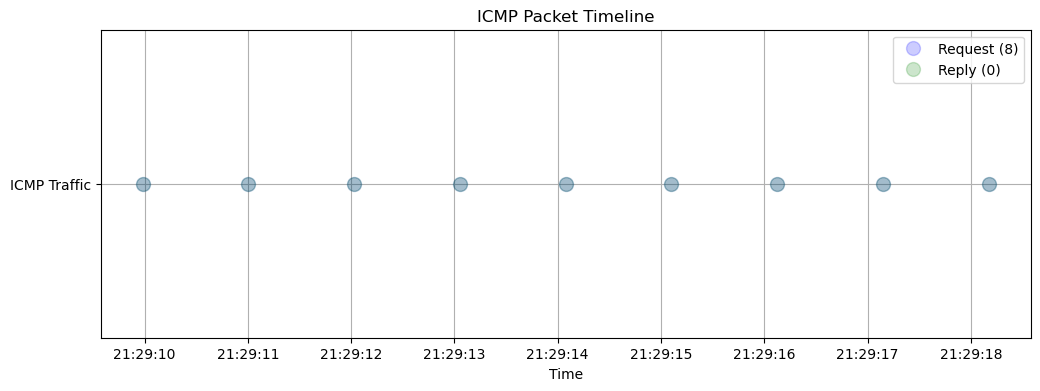

In [17]:
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime

# Convert timestamp to datetime and filter ICMP traffic
df['timestamp'] = pd.to_datetime(df['timestamp'])
icmp = df[df['protocol'] == 1.0].copy()

# Create timeline plot
plt.figure(figsize=(12, 4))
for _, row in icmp.iterrows():
    color = 'blue' if row['icmp_type'] == 8 else 'green'
    plt.plot(row['timestamp'], 1, 'o', color=color, markersize=10, alpha = 0.2)

plt.yticks([1], ['ICMP Traffic'])
plt.title('ICMP Packet Timeline')
plt.xlabel('Time')
plt.legend(['Request (8)', 'Reply (0)'])
plt.grid(True)
plt.show()

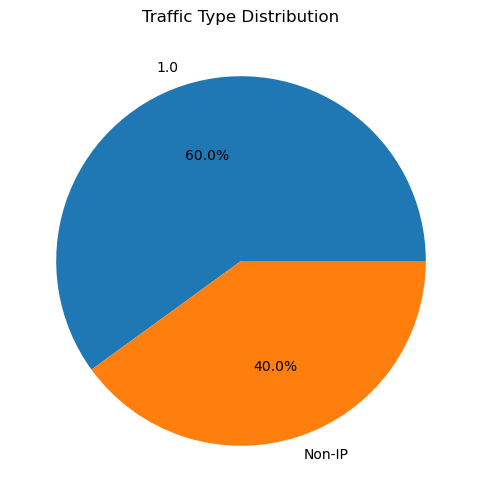

In [18]:
# Protocol distribution
protocol_dist = df['protocol'].fillna('Non-IP').value_counts()

plt.figure(figsize=(6, 6))
plt.pie(protocol_dist, labels=protocol_dist.index, autopct='%1.1f%%')
plt.title('Traffic Type Distribution')
plt.show()

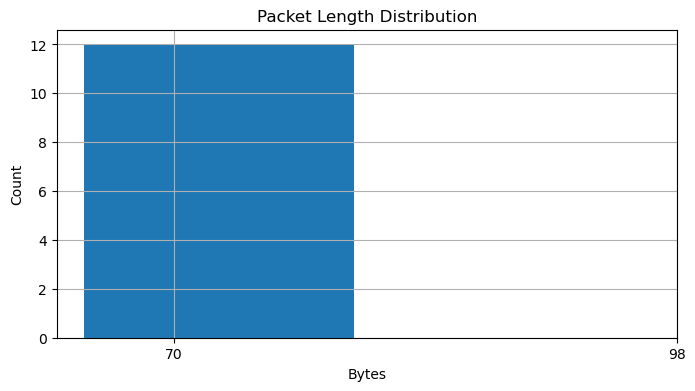

In [19]:
plt.figure(figsize=(8, 4))
df['length'].hist(bins=[65, 80, 95])
plt.title('Packet Length Distribution')
plt.xlabel('Bytes')
plt.ylabel('Count')
plt.xticks([70, 98])
plt.show()

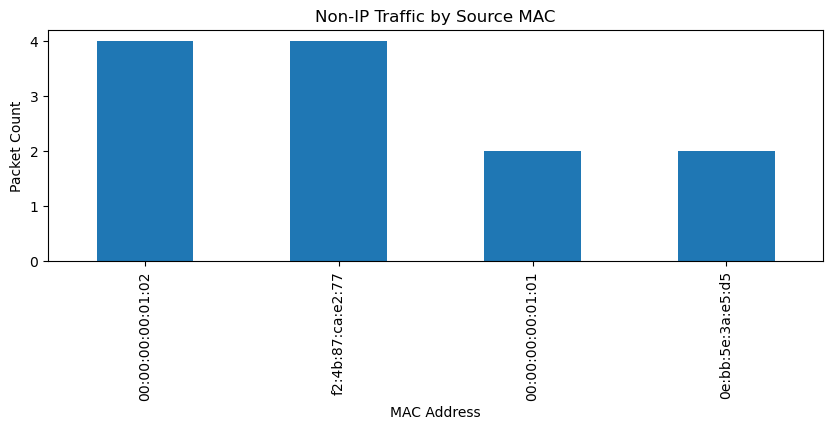

In [20]:
non_ip = df[df['protocol'].isna()]
mac_counts = non_ip['src_mac'].value_counts()

plt.figure(figsize=(10, 3))
mac_counts.plot(kind='bar')
plt.title('Non-IP Traffic by Source MAC')
plt.xlabel('MAC Address')
plt.ylabel('Packet Count')
plt.show()

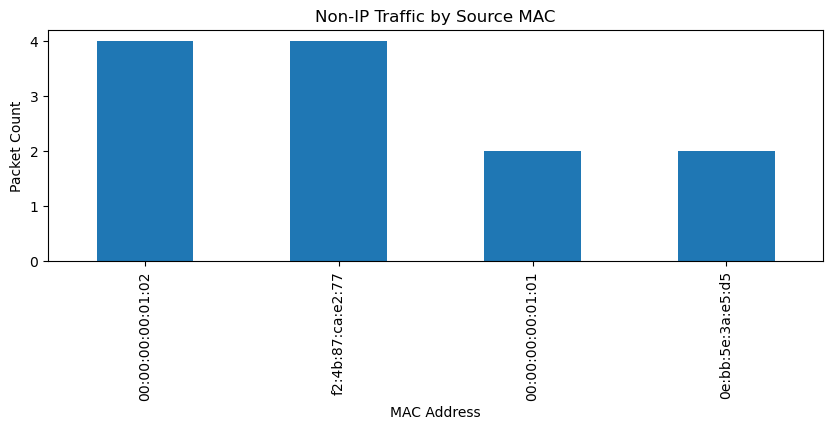

In [21]:
non_ip = df[df['protocol'].isna()]
mac_counts = non_ip['src_mac'].value_counts()

plt.figure(figsize=(10, 3))
mac_counts.plot(kind='bar')
plt.title('Non-IP Traffic by Source MAC')
plt.xlabel('MAC Address')
plt.ylabel('Packet Count')
plt.show()

ValueError: x and y must have same first dimension, but have shapes (13,) and (14,)

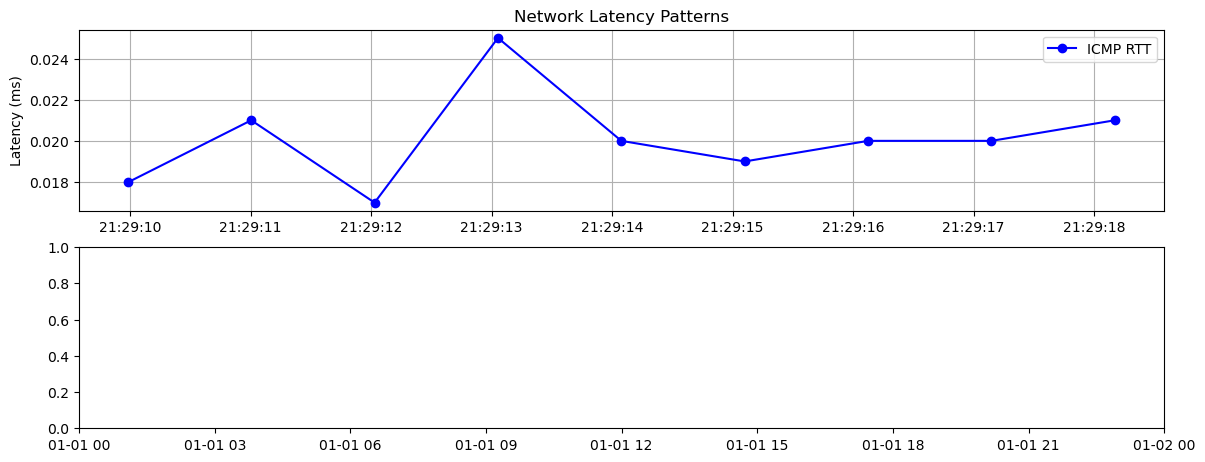

In [22]:
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime

# Convert timestamp and filter ICMP traffic
df['timestamp'] = pd.to_datetime(df['timestamp'])
icmp = df[df['protocol'] == 1.0].copy()

# Create figure with subplots
plt.figure(figsize=(14, 8))

# 1. ICMP Round Trip Time Timeline
plt.subplot(3, 1, 1)
requests = icmp[icmp['icmp_type'] == 8.0]
replies = icmp[icmp['icmp_type'] == 0.0]

# Calculate response times
rtts = []
timestamps = []
for idx, req in requests.iterrows():
    reply = replies[(replies['timestamp'] > req['timestamp']) & 
                    (replies['src_ip'] == req['dst_ip'])]
    if not reply.empty:
        rtt = (reply.iloc[0]['timestamp'] - req['timestamp']).total_seconds() * 1000
        rtts.append(rtt)
        timestamps.append(req['timestamp'])

plt.plot(timestamps, rtts, 'b-o', label='ICMP RTT')
plt.title('Network Latency Patterns')
plt.ylabel('Latency (ms)')
plt.grid(True)
plt.legend()
plt.savefig('NetworkLath1eth.png')


# 2. Traffic Volume Over Time
plt.subplot(3, 1, 2)
time_bins = pd.date_range(start=df['timestamp'].min(), end=df['timestamp'].max(), freq='1s')
plt.plot(time_bins, df.groupby(pd.Grouper(key='timestamp', freq='1s')).size(), 
         'g-', label='Total Traffic')
plt.ylabel('Packets/sec')
plt.grid(True)
plt.legend()

# 3. Protocol Type Distribution Over Time
plt.subplot(3, 1, 3)
icmp_traffic = df[df['protocol'] == 1.0].groupby(pd.Grouper(key='timestamp', freq='1s')).size()
non_ip_traffic = df[df['protocol'].isna()].groupby(pd.Grouper(key='timestamp', freq='1s')).size()

plt.plot(icmp_traffic, 'r--', label='ICMP Traffic')
plt.plot(non_ip_traffic, 'm:', label='Non-IP Traffic')
plt.ylabel('Packets/sec')
plt.xlabel('Time')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

In [23]:
import scapy.all as scapy
import pandas as pd
from datetime import datetime

def pcap_to_csv(pcap_file, output_csv):
    packets = scapy.rdpcap(pcap_file)  # Read the PCAP file
    
    data = []
    for pkt in packets:
        if pkt.haslayer(scapy.IP):
            timestamp = datetime.fromtimestamp(float(pkt.time))  # Convert timestamp to datetime
            src_ip = pkt[scapy.IP].src
            dst_ip = pkt[scapy.IP].dst
            data.append([timestamp, src_ip, dst_ip])
    
    df = pd.DataFrame(data, columns=['timestamp', 'src_ip', 'dst_ip'])
    df.to_csv(output_csv, index=False)

# Convert both PCAP files
pcap_to_csv('h1_capture.pcap', 'h1_capture.csv')
pcap_to_csv('h2_capture.pcap', 'h2_capture.csv')


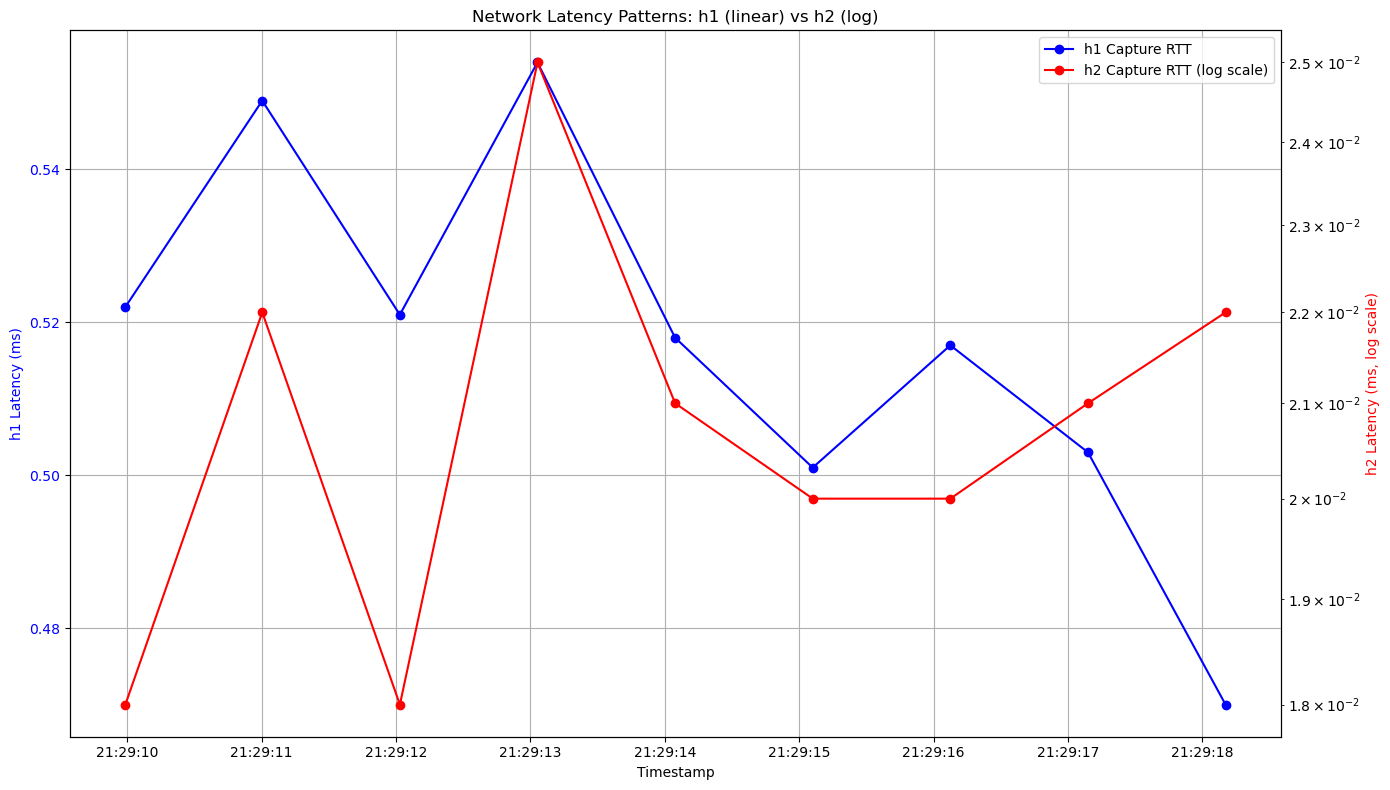

In [24]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSVs
h1_requests = pd.read_csv('h1_capture.csv')
h2_requests = pd.read_csv('h2_capture.csv')

# Convert timestamp column to datetime
h1_requests['timestamp'] = pd.to_datetime(h1_requests['timestamp'])
h2_requests['timestamp'] = pd.to_datetime(h2_requests['timestamp'])

# Function to calculate RTTs
def calculate_rtt(requests, replies, max_reply_delay=0.01):  # max_reply_delay in seconds (e.g., 10ms)
    rtts = []
    timestamps = []
    for idx, req in requests.iterrows():
        reply = replies[(replies['timestamp'] > req['timestamp']) & 
                        (replies['timestamp'] <= req['timestamp'] + pd.Timedelta(seconds=max_reply_delay)) &
                        (replies['src_ip'] == req['dst_ip']) &
                        (replies['dst_ip'] == req['src_ip'])]
        if not reply.empty:
            rtt = (reply.iloc[0]['timestamp'] - req['timestamp']).total_seconds() * 1000  # RTT in ms
            rtts.append(rtt)
            timestamps.append(req['timestamp'])
    return rtts, timestamps

# Calculate RTTs for both datasets
rtts_h1, timestamps_h1 = calculate_rtt(h1_requests, h1_requests)
rtts_h2, timestamps_h2 = calculate_rtt(h2_requests, h2_requests)

# Create the combined plot
plt.figure(figsize=(14, 8))

# Plot RTT for h1 on primary y-axis
ax1 = plt.gca()  # Get current axis
ax1.plot(timestamps_h1, rtts_h1, 'b-o', label='h1 Capture RTT')
ax1.set_xlabel('Timestamp')
ax1.set_ylabel('h1 Latency (ms)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.grid(True)

# Create secondary y-axis for h2 with log scale
ax2 = ax1.twinx()
ax2.plot(timestamps_h2, rtts_h2, 'r-o', label='h2 Capture RTT (log scale)')
ax2.set_yscale('log')  # Apply logarithmic scale
ax2.set_ylabel('h2 Latency (ms, log scale)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Add title and legend
plt.title('Network Latency Patterns: h1 (linear) vs h2 (log)')
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

# Adjust layout and save
plt.tight_layout()
plt.savefig('Network_Latency_Patterns_Combined.png')
plt.show()

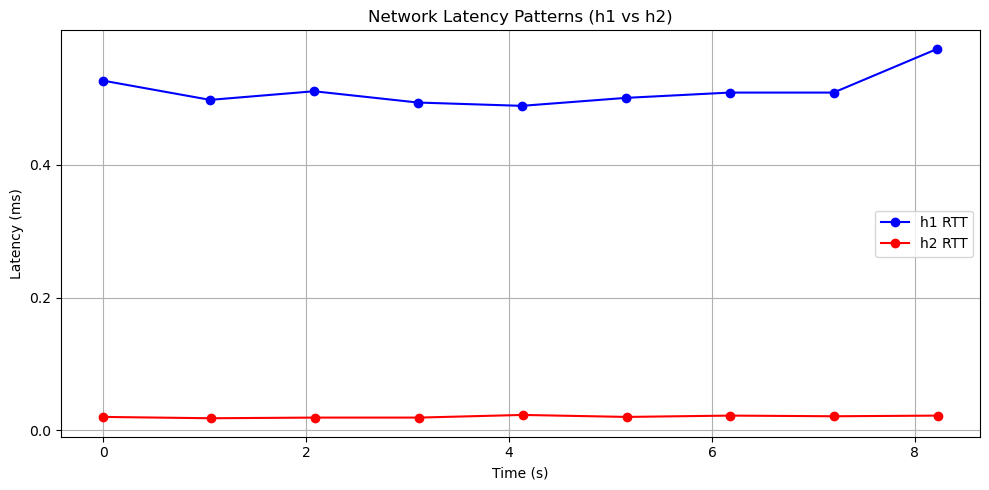

In [80]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSVs
h1_requests = pd.read_csv('h1_capture.csv')
h2_requests = pd.read_csv('h2_capture.csv')

# Convert timestamp column to datetime
h1_requests['timestamp'] = pd.to_datetime(h1_requests['timestamp'])
h2_requests['timestamp'] = pd.to_datetime(h2_requests['timestamp'])

# Initialize lists for RTTs and timestamps
rtts_h1 = []
rtts_h2 = []
timestamps_h1 = []
timestamps_h2 = []

# Function to calculate RTTs
def calculate_rtt(requests, replies, max_reply_delay=0.01):  # max_reply_delay in seconds (e.g., 10ms)
    rtts = []
    timestamps = []
    for idx, req in requests.iterrows():
        reply = replies[(replies['timestamp'] > req['timestamp']) & 
                        (replies['timestamp'] <= req['timestamp'] + pd.Timedelta(seconds=max_reply_delay)) &
                        (replies['src_ip'] == req['dst_ip']) &
                        (replies['dst_ip'] == req['src_ip'])]
        if not reply.empty:
            rtt = (reply.iloc[0]['timestamp'] - req['timestamp']).total_seconds() * 1000  # RTT in ms
            rtts.append(rtt)
            timestamps.append(req['timestamp'])
    return rtts, timestamps


# Calculate RTTs for both datasets
rtts_h1, timestamps_h1 = calculate_rtt(h1_requests, h1_requests)
rtts_h2, timestamps_h2 = calculate_rtt(h2_requests, h2_requests)

# Convert timestamps lists to pandas Series
timestamps_h1_series = pd.Series(timestamps_h1)
timestamps_h2_series = pd.Series(timestamps_h2)

# Convert timestamps to seconds (relative to the first timestamp)
timestamps_h1_seconds = (timestamps_h1_series - timestamps_h1_series.iloc[0]).dt.total_seconds()
timestamps_h2_seconds = (timestamps_h2_series - timestamps_h2_series.iloc[0]).dt.total_seconds()

# Create the plot
plt.figure(figsize=(10, 5))

# Plot RTT for h1
plt.plot(timestamps_h1_seconds, rtts_h1, 'b-o', label='h1 RTT')

# Plot RTT for h2
plt.plot(timestamps_h2_seconds, rtts_h2, 'r-o', label='h2 RTT')

# Title and labels
plt.title('Network Latency Patterns (h1 vs h2)')
plt.ylabel('Latency (ms)')
plt.xlabel('Time (s)')

# Set y-axis ticks to 0.2, 0.4, 0.6, etc.
plt.yticks([0.2 * i for i in range(int(max(rtts_h1 + rtts_h2) / 0.2) + 1)])

# Grid and legend
plt.grid(True)
plt.legend()

# Save the plot
plt.tight_layout()
plt.savefig('Network_Latency_Patterns.png')
plt.show()


In [ ]:
!pip list

In [35]:
import os
import subprocess
import time
from mininet.net import Mininet
from mininet.topo import Topo
from mininet.node import Switch
from mininet.cli import CLI
from mininet.log import setLogLevel, info

class P4Switch(Switch):
    def __init__(self, name, json_file, thrift_port=9090, **params):
        Switch.__init__(self, name, **params)
        self.json_file = json_file
        self.thrift_port = thrift_port
        self.interfaces = []

    def start(self, controllers):
        intf_args = " ".join(f"--interface {idx}@{intf.name}" for idx, intf in enumerate(self.intfList()) if intf.name != "lo")
        cmd = f"simple_switch --thrift-port {self.thrift_port} --log-console --log-level trace {intf_args} {self.json_file} &"
        info(f"*** Starting P4 switch {self.name}: {cmd}\n")
        os.system(cmd)
        time.sleep(5)

    def stop(self):
        info(f"*** Stopping P4 switch {self.name}\n")
        os.system("pkill simple_switch")

class NetworkTopo(Topo):
    def __init__(self, json_file):
        Topo.__init__(self)
        s1 = self.addSwitch('s1', cls=P4Switch, json_file=json_file, thrift_port=9090)
        h1 = self.addHost('h1', ip='10.0.1.1/24', mac='00:00:00:00:01:01')
        h2 = self.addHost('h2', ip='10.0.1.2/24', mac='00:00:00:00:01:02')
        self.addLink(h1, s1, port1=0, port2=0)
        self.addLink(h2, s1, port1=0, port2=1)

def compile_p4_program(p4_file):
    if not os.path.isfile(p4_file):
        info(f"*** ERROR: P4 file '{p4_file}' not found. Aborting compilation.\n")
        return False
    print(f"Compiling P4 program: {p4_file}...")
    try:
        subprocess.run(['p4c', '--target', 'bmv2', '--arch', 'v1model', '-o', '.', p4_file], check=True)
        print("P4 compilation successful")
        time.sleep(5)
        return True
    except subprocess.CalledProcessError as e:
        print(f"P4 compilation failed: {e}")
        return False

def setup_network(p4_file):
    json_file = p4_file.replace('.p4', '.json')
    if compile_p4_program(p4_file):
        info(f"*** Using compiled JSON: {json_file}\n")
    else:
        info(f"*** WARNING: Compilation failed for {p4_file}. Switch may run without valid P4 program.\n")
    
    net = Mininet(topo=NetworkTopo(json_file), controller=None)
    try:
        net.start()
        s1 = net.get('s1')
        s1.cmd('simple_switch_CLI --thrift-port 9090 << EOF\n'
               'mc_mgrp_create 1\n'
               'mc_node_create 0 0 1\n'
               'mc_node_associate 1 0\n'
               'table_add ipv4_lpm forward 10.0.1.1/32 => 0\n'
               'table_add ipv4_lpm forward 10.0.1.2/32 => 1\n'
               'EOF')
        
        h1, h2 = net.get('h1', 'h2')
        h1.cmd('ifconfig h1-eth0 10.0.1.1/24 up')
        h2.cmd('ifconfig h2-eth0 10.0.1.2/24 up')
        h1.cmd('arp -i h1-eth0 -s 10.0.1.2 00:00:00:00:01:02')
        h2.cmd('arp -i h2-eth0 -s 10.0.1.1 00:00:00:00:01:01')
        h1.cmd('ip route add 10.0.1.0/24 dev h1-eth0')
        h2.cmd('ip route add 10.0.1.0/24 dev h2-eth0')
        
        info("*** h1 interface config:\n")
        print(h1.cmd('ifconfig h1-eth0'))
        info("*** h1 ARP table:\n")
        print(h1.cmd('arp -n'))
        info("*** h2 interface config:\n")
        print(h2.cmd('ifconfig h2-eth0'))

        info("*** Starting tcpdump on h2-eth0:\n")
        h2.cmd('tcpdump -i h2-eth0 -w h2_capture.pcap &')
        time.sleep(5)
        
        info("*** Pinging from h1 to h2:\n")
        print(h1.cmd('ping -c 10 10.0.1.2'))
        
        h1.cmd('pkill tcpdump')
        info("*** tcpdump output (check h1_capture.pcap manually):\n")
        
        info("*** Pinging h1 to h2 with net.ping:\n")
        print(net.ping([h1, h2]))

        info("*** Starting tcpdump on h1-eth0:\n")
        h1.cmd('tcpdump -i h1-eth0 -w h1_capture.pcap &')
        time.sleep(5)
        
        info("*** Pinging from h1 to h2:\n")
        print(h1.cmd('ping -c 10 10.0.1.2'))
        
        h1.cmd('pkill tcpdump')
        info("*** tcpdump output (check h1_capture.pcap manually):\n")
        
        info("*** Pinging h2 to h1 with net.ping:\n")
        print(net.ping([h2, h1]))
        
        CLI(net)
    finally:
        net.stop()

def main():
    setLogLevel('info')
    os.system('sudo pkill -f simple_switch')
    for tool in ['p4c', 'simple_switch', 'simple_switch_CLI']:
        if subprocess.run(['which', tool], capture_output=True).returncode != 0:
            print(f"ERROR: {tool} not found in PATH!")
            return
    
    # Choose your P4 file here
    p4_file = "forward_G.p4"  # Options: "forward.p4", "drop.p4", "rerouting.p4"
    setup_network(p4_file)


main()

Compiling P4 program: forward_G.p4...
P4 compilation successful


*** Using compiled JSON: forward_G.json
*** Creating network
*** Adding hosts:
h1 h2 
*** Adding switches:
s1 
*** Adding links:
(h1, s1) (h2, s1) 
*** Configuring hosts
h1 h2 
*** Starting controller

*** Starting 1 switches
s1 *** Starting P4 switch s1: simple_switch --thrift-port 9090 --log-console --log-level trace --interface 0@s1-eth0 --interface 1@s1-eth1 forward_G.json &


Calling target program-options parser
[21:40:30.926] [bmv2] [D] [thread 20637] Set default default entry for table 'MyIngress.ipv4_lpm': MyIngress.forward - 0,
[21:40:30.926] [bmv2] [D] [thread 20637] Set default default entry for table 'MyIngress.ethernet_exact': MyIngress.broadcast - 
Adding interface s1-eth0 as port 0
[21:40:30.926] [bmv2] [D] [thread 20637] Adding interface s1-eth0 as port 0
Adding interface s1-eth1 as port 1
[21:40:30.936] [bmv2] [D] [thread 20637] Adding interface s1-eth1 as port 1
[21:40:30.945] [bmv2] [I] [thread 20637] Starting Thrift server on port 9090
[21:40:30.946] [bmv2] [I] [thread 20637] Thrift server was started
[21:40:31.092] [bmv2] [D] [thread 20643] [0.0] [cxt 0] Processing packet received on port 0
[21:40:31.092] [bmv2] [D] [thread 20643] [0.0] [cxt 0] Parser 'parser': start
[21:40:31.092] [bmv2] [D] [thread 20643] [0.0] [cxt 0] Parser 'parser' entering state 'start'
[21:40:31.092] [bmv2] [D] [thread 20643] [0.0] [cxt 0] Extracting header 'ethernet


*** h1 interface config:
*** h1 ARP table:
*** h2 interface config:
*** Starting tcpdump on h2-eth0:


[21:40:35.979] [bmv2] [T] [thread 20651] bm_get_config
[21:40:35.981] [bmv2] [T] [thread 20651] bm_mc_mgrp_create
[21:40:35.981] [bmv2] [D] [thread 20651] mgrp node created for mgid 1
[21:40:35.981] [bmv2] [T] [thread 20651] bm_mc_node_create
[21:40:35.981] [bmv2] [D] [thread 20651] node created for rid 0
[21:40:35.981] [bmv2] [T] [thread 20651] bm_mc_node_associate
[21:40:35.981] [bmv2] [D] [thread 20651] node associated with mgid 1
[21:40:35.981] [bmv2] [T] [thread 20651] bm_table_add_entry
[21:40:35.981] [bmv2] [D] [thread 20651] Entry 0 added to table 'MyIngress.ipv4_lpm'
[21:40:35.981] [bmv2] [D] [thread 20651] Dumping entry 0
Match key:
* hdr.ipv4.dstAddr    : LPM       0a000101/32
Action entry: MyIngress.forward - 0,

[21:40:35.982] [bmv2] [T] [thread 20651] bm_table_add_entry
[21:40:35.982] [bmv2] [D] [thread 20651] Entry 1 added to table 'MyIngress.ipv4_lpm'
[21:40:35.982] [bmv2] [D] [thread 20651] Dumping entry 1
Match key:
* hdr.ipv4.dstAddr    : LPM       0a000102/32
Action

*** Pinging from h1 to h2:


[21:40:41.013] [bmv2] [D] [thread 20643] [24.0] [cxt 0] Processing packet received on port 0
[21:40:41.013] [bmv2] [D] [thread 20643] [24.0] [cxt 0] Parser 'parser': start
[21:40:41.013] [bmv2] [D] [thread 20643] [24.0] [cxt 0] Parser 'parser' entering state 'start'
[21:40:41.013] [bmv2] [D] [thread 20643] [24.0] [cxt 0] Extracting header 'ethernet'
[21:40:41.013] [bmv2] [D] [thread 20643] [24.0] [cxt 0] Parser state 'start': key is 0800
[21:40:41.013] [bmv2] [T] [thread 20643] [24.0] [cxt 0] Bytes parsed: 14
[21:40:41.013] [bmv2] [D] [thread 20643] [24.0] [cxt 0] Parser 'parser' entering state 'parse_ipv4'
[21:40:41.013] [bmv2] [D] [thread 20643] [24.0] [cxt 0] Extracting header 'ipv4'
[21:40:41.013] [bmv2] [D] [thread 20643] [24.0] [cxt 0] Parser state 'parse_ipv4' has no switch, going to default next state
[21:40:41.013] [bmv2] [T] [thread 20643] [24.0] [cxt 0] Bytes parsed: 34
[21:40:41.013] [bmv2] [D] [thread 20643] [24.0] [cxt 0] Parser 'parser': end
[21:40:41.013] [bmv2] [D] [th

*** tcpdump output (check h1_capture.pcap manually):
*** Pinging h1 to h2 with net.ping:
h1 -> h2 
h2 -> h1 
*** Results: 0% dropped (2/2 received)
*** Starting tcpdump on h1-eth0:


[21:40:50.268] [bmv2] [D] [thread 20643] [46.0] [cxt 0] Processing packet received on port 0
[21:40:50.268] [bmv2] [D] [thread 20643] [46.0] [cxt 0] Parser 'parser': start
[21:40:50.268] [bmv2] [D] [thread 20643] [46.0] [cxt 0] Parser 'parser' entering state 'start'
[21:40:50.268] [bmv2] [D] [thread 20643] [46.0] [cxt 0] Extracting header 'ethernet'
[21:40:50.268] [bmv2] [D] [thread 20643] [46.0] [cxt 0] Parser state 'start': key is 0800
[21:40:50.268] [bmv2] [T] [thread 20643] [46.0] [cxt 0] Bytes parsed: 14
[21:40:50.268] [bmv2] [D] [thread 20643] [46.0] [cxt 0] Parser 'parser' entering state 'parse_ipv4'
[21:40:50.268] [bmv2] [D] [thread 20643] [46.0] [cxt 0] Extracting header 'ipv4'
[21:40:50.268] [bmv2] [D] [thread 20643] [46.0] [cxt 0] Parser state 'parse_ipv4' has no switch, going to default next state
[21:40:50.268] [bmv2] [T] [thread 20643] [46.0] [cxt 0] Bytes parsed: 34
[21:40:50.268] [bmv2] [D] [thread 20643] [46.0] [cxt 0] Parser 'parser': end
[21:40:50.268] [bmv2] [D] [th

*** Pinging from h1 to h2:


[21:40:55.293] [bmv2] [D] [thread 20643] [52.0] [cxt 0] Processing packet received on port 0
[21:40:55.293] [bmv2] [D] [thread 20643] [52.0] [cxt 0] Parser 'parser': start
[21:40:55.293] [bmv2] [D] [thread 20643] [52.0] [cxt 0] Parser 'parser' entering state 'start'
[21:40:55.293] [bmv2] [D] [thread 20643] [52.0] [cxt 0] Extracting header 'ethernet'
[21:40:55.293] [bmv2] [D] [thread 20643] [52.0] [cxt 0] Parser state 'start': key is 0800
[21:40:55.293] [bmv2] [T] [thread 20643] [52.0] [cxt 0] Bytes parsed: 14
[21:40:55.293] [bmv2] [D] [thread 20643] [52.0] [cxt 0] Parser 'parser' entering state 'parse_ipv4'
[21:40:55.293] [bmv2] [D] [thread 20643] [52.0] [cxt 0] Extracting header 'ipv4'
[21:40:55.293] [bmv2] [D] [thread 20643] [52.0] [cxt 0] Parser state 'parse_ipv4' has no switch, going to default next state
[21:40:55.293] [bmv2] [T] [thread 20643] [52.0] [cxt 0] Bytes parsed: 34
[21:40:55.293] [bmv2] [D] [thread 20643] [52.0] [cxt 0] Parser 'parser': end
[21:40:55.293] [bmv2] [D] [th

*** tcpdump output (check h1_capture.pcap manually):
*** Pinging h2 to h1 with net.ping:
h2 -> h1 
h1 -> h2 
*** Results: 0% dropped (2/2 received)
*** Starting CLI:


[21:41:04.540] [bmv2] [D] [thread 20643] [74.0] [cxt 0] Processing packet received on port 0
[21:41:04.540] [bmv2] [D] [thread 20643] [74.0] [cxt 0] Parser 'parser': start
[21:41:04.540] [bmv2] [D] [thread 20643] [74.0] [cxt 0] Parser 'parser' entering state 'start'
[21:41:04.540] [bmv2] [D] [thread 20643] [74.0] [cxt 0] Extracting header 'ethernet'
[21:41:04.540] [bmv2] [D] [thread 20643] [74.0] [cxt 0] Parser state 'start': key is 0800
[21:41:04.540] [bmv2] [T] [thread 20643] [74.0] [cxt 0] Bytes parsed: 14
[21:41:04.540] [bmv2] [D] [thread 20643] [74.0] [cxt 0] Parser 'parser' entering state 'parse_ipv4'
[21:41:04.540] [bmv2] [D] [thread 20643] [74.0] [cxt 0] Extracting header 'ipv4'
[21:41:04.540] [bmv2] [D] [thread 20643] [74.0] [cxt 0] Parser state 'parse_ipv4' has no switch, going to default next state
[21:41:04.540] [bmv2] [T] [thread 20643] [74.0] [cxt 0] Bytes parsed: 34
[21:41:04.540] [bmv2] [D] [thread 20643] [74.0] [cxt 0] Parser 'parser': end
[21:41:04.540] [bmv2] [D] [th

mininet>  exit


*** Stopping 0 controllers

*** Stopping 2 links
..
*** Stopping 1 switches
s1 *** Stopping P4 switch s1
open: No such file or directory
open: No such file or directory

*** Stopping 2 hosts
h1 h2 
*** Done


# QoS Fast Rerouting

In [1]:
import os
import subprocess
import time
from mininet.net import Mininet
from mininet.topo import Topo
from mininet.node import Switch
from mininet.link import TCLink
from mininet.cli import CLI
from mininet.log import setLogLevel, info, error

class P4Switch(Switch):
    def __init__(self, name, json_file, thrift_port, device_id, **params):
        Switch.__init__(self, name, **params)
        self.json_file = json_file
        self.thrift_port = thrift_port
        self.device_id = device_id
        self.proc = None

    def start(self, controllers):
        cmd = [
            'simple_switch',
            '--thrift-port', str(self.thrift_port),
            '--device-id', str(self.device_id),
            '--nanolog', f'ipc:///tmp/bm-{self.device_id}-log.ipc',
            '--log-console',
            self.json_file
        ]
        for idx, intf in enumerate(self.intfList()):
            if intf.name != "lo":
                cmd.extend(['-i', f"{idx+1}@{intf.name}"])
        info(f"Starting P4 switch {self.name}: {' '.join(cmd)}\n")
        self.proc = subprocess.Popen(
            cmd,
            stdout=open(f'{self.name}.log', 'w'),
            stderr=subprocess.STDOUT
        )
        time.sleep(1)

    def stop(self):
        if self.proc:
            self.proc.terminate()
            self.proc.wait()

class FastRerouteTopo(Topo):
    def __init__(self, json_file):
        Topo.__init__(self)
        switches = []
        for i in range(1, 4):
            sw = self.addSwitch(
                f's{i}',
                cls=P4Switch,
                json_file=json_file,
                thrift_port=9090 + (i-1),
                device_id=i
            )
            switches.append(sw)

        hosts = []
        for i in range(1, 4):
            host = self.addHost(
                f'h{i}',
                ip=f'10.0.{i}.1/24',
                mac=f'00:00:00:00:0{i}:01',
                defaultRoute=f'via 10.0.{i}.254'
            )
            hosts.append(host)
            self.addLink(host, switches[i-1], port1=0, port2=2, cls=TCLink, bw=100, delay='1ms')

        # Primary links
        self.addLink(switches[0], switches[1], port1=3, port2=3, cls=TCLink, bw=50, delay='1ms')  # s1-s2
        self.addLink(switches[1], switches[2], port1=4, port2=3, cls=TCLink, bw=50, delay='1ms')  # s2-s3
        self.addLink(switches[2], switches[0], port1=4, port2=4, cls=TCLink, bw=50, delay='1ms')  # s3-s1

        # Backup links
        self.addLink(switches[0], switches[1], port1=5, port2=5, cls=TCLink, bw=30, delay='10ms')  # s1-s2
        self.addLink(switches[1], switches[2], port1=6, port2=5, cls=TCLink, bw=30, delay='10ms')  # s2-s3
        self.addLink(switches[2], switches[0], port1=6, port2=6, cls=TCLink, bw=30, delay='10ms')  # s3-s1

def configure_switch(sw):
    thrift_port = sw.thrift_port
    config = [
        'register_write link_status 2 1',  # Port to host
        'register_write link_status 3 1',  # Primary port
        'register_write link_status 4 1',  # Primary port
        'register_write link_status 5 1',  # Backup port
        'register_write link_status 6 1',  # Backup port
    ]

    if sw.name == 's1':
        config += [
            'table_add arp_table generate_arp_reply 10.0.1.254 => 00:00:00:00:01:01 10.0.1.254',
            'table_add ipv4_lpm set_routes 10.0.1.1/32 => 2 00:00:00:00:01:01 0 00:00:00:00:00:00 00:00:00:00:01:01',
            'table_add ipv4_lpm set_routes 10.0.2.1/32 => 3 00:00:00:00:02:02 5 00:00:00:00:02:04 00:00:00:00:01:02',
            'table_add ipv4_lpm set_routes 10.0.3.1/32 => 4 00:00:00:00:03:03 6 00:00:00:00:03:06 00:00:00:00:01:03',
            'table_add backup_routes set_backup_nhop 10.0.2.1/32 => 00:00:00:00:02:04 5 00:00:00:00:01:04',
            'table_add backup_routes set_backup_nhop 10.0.3.1/32 => 00:00:00:00:03:06 6 00:00:00:00:01:06',
        ]
    elif sw.name == 's2':
        config += [
            'table_add arp_table generate_arp_reply 10.0.2.254 => 00:00:00:00:02:01 10.0.2.254',
            'table_add ipv4_lpm set_routes 10.0.2.1/32 => 2 00:00:00:00:02:01 0 00:00:00:00:00:00 00:00:00:00:02:01',
            'table_add ipv4_lpm set_routes 10.0.3.1/32 => 4 00:00:00:00:03:03 6 00:00:00:00:03:05 00:00:00:00:02:03',
            'table_add ipv4_lpm set_routes 10.0.1.1/32 => 3 00:00:00:00:01:02 5 00:00:00:00:01:04 00:00:00:00:02:02',
            'table_add backup_routes set_backup_nhop 10.0.3.1/32 => 00:00:00:00:03:05 6 00:00:00:00:02:05',
            'table_add backup_routes set_backup_nhop 10.0.1.1/32 => 00:00:00:00:01:04 5 00:00:00:00:02:04',
        ]
    elif sw.name == 's3':
        config += [
            'table_add arp_table generate_arp_reply 10.0.3.254 => 00:00:00:00:03:01 10.0.3.254',
            'table_add ipv4_lpm set_routes 10.0.3.1/32 => 2 00:00:00:00:03:01 0 00:00:00:00:00:00 00:00:00:00:03:01',
            'table_add ipv4_lpm set_routes 10.0.1.1/32 => 4 00:00:00:00:01:03 6 00:00:00:00:01:06 00:00:00:00:03:02',
            'table_add ipv4_lpm set_routes 10.0.2.1/32 => 3 00:00:00:00:02:03 5 00:00:00:00:02:05 00:00:00:00:03:03',
            'table_add backup_routes set_backup_nhop 10.0.1.1/32 => 00:00:00:00:01:06 6 00:00:00:00:03:06',
            'table_add backup_routes set_backup_nhop 10.0.2.1/32 => 00:00:00:00:02:05 5 00:00:00:00:03:05',
        ]

    try:
        subprocess.run(
            ['simple_switch_CLI', '--thrift-port', str(thrift_port)],
            input='\n'.join(config),
            text=True,
            check=True,
            timeout=10
        )
        info(f"Configured switch {sw.name} successfully\n")
    except subprocess.SubprocessError as e:
        error(f"Failed to configure {sw.name}: {str(e)}\n")

def read_registers(net, switch_name, thrift_port, output_file):
    info(f"\n*** {switch_name} Registers:\n")
    with open(output_file, 'w') as f:
        subprocess.run(f"echo 'register_read link_status' | simple_switch_CLI --thrift-port {thrift_port}", shell=True, stdout=f)
        subprocess.run(f"echo 'register_read backup_counter' | simple_switch_CLI --thrift-port {thrift_port}", shell=True, stdout=f)
        subprocess.run(f"echo 'register_read drop_counter' | simple_switch_CLI --thrift-port {thrift_port}", shell=True, stdout=f)
        subprocess.run(f"echo 'register_read active_port' | simple_switch_CLI --thrift-port {thrift_port}", shell=True, stdout=f)
        subprocess.run(f"echo 'register_read h1_to_h2_active_port' | simple_switch_CLI --thrift-port {thrift_port}", shell=True, stdout=f)
    with open(output_file, 'r') as f:
        info(f.read())

def log_registers_periodically(net, switch_name, thrift_port, base_filename):
    for i in range(20):  # Log every 2 seconds for 40 seconds
        time.sleep(2)
        timestamp = i * 2
        output_file = f"{base_filename}_t{timestamp}.txt"
        info(f"*** Logging {switch_name} Registers at {timestamp} seconds\n")
        with open(output_file, 'w') as f:
            subprocess.run(f"echo 'register_read h1_to_h2_active_port' | simple_switch_CLI --thrift-port {thrift_port}", shell=True, stdout=f)
        with open(output_file, 'r') as f:
            info(f.read())

def compile_p4_program(p4_file):
    json_file = p4_file.replace('.p4', '.json')
    try:
        result = subprocess.run(
            ['p4c-bm2-ss', '--std', 'p4-16', '-o', json_file, p4_file],
            check=True,
            capture_output=True,
            text=True
        )
        info("P4 compilation succeeded:\n" + result.stderr + "\n")
        return json_file
    except subprocess.CalledProcessError as e:
        error("P4 compilation failed:\n" + e.stderr + "\n")
        return None

def execute_switch_cmd(net, switch_name, thrift_port, cmd):
    try:
        result = subprocess.run(
            ['simple_switch_CLI', '--thrift-port', str(thrift_port)],
            input=cmd,
            text=True,
            capture_output=True,
            check=True,
            timeout=5
        )
        info(f"Executed '{cmd}' on {switch_name}: {result.stdout}\n")
        return True
    except subprocess.SubprocessError as e:
        error(f"Failed to execute '{cmd}' on {switch_name}: {e.stderr}\n")
        return False

def verify_link_delays(net):
    info("*** Verifying link delays\n")
    s1 = net.get('s1')
    s2 = net.get('s2')
    # Verify primary link (should be 1ms)
    info("Primary link s1-eth3 delay:\n")
    s1.cmdPrint('tc qdisc show dev s1-eth3')
    info("Primary link s2-eth3 delay:\n")
    s2.cmdPrint('tc qdisc show dev s2-eth3')
    # Verify backup link (should be 10ms)
    info("Backup link s1-eth5 delay:\n")
    s1.cmdPrint('tc qdisc show dev s1-eth5')
    info("Backup link s2-eth5 delay:\n")
    s2.cmdPrint('tc qdisc show dev s2-eth5')
    # Ensure backup link delay is set correctly
    s1.cmd('tc qdisc replace dev s1-eth5 root netem delay 10ms')
    s2.cmd('tc qdisc replace dev s2-eth5 root netem delay 10ms')
    info("Backup link delays set to 10ms\n")

def main():
    setLogLevel('info')
    os.system('pkill -f "simple_switch|bmv2"')
    
    json_file = compile_p4_program("fast_reroute.p4")
    if not json_file:
        error("Failed to compile P4 program\n")
        return

    net = Mininet(
        topo=FastRerouteTopo(json_file),
        controller=None,
        link=TCLink,
        autoSetMacs=True
    )
    net.start()

    try:
        # Configure switches
        for sw in net.switches:
            configure_switch(sw)
            time.sleep(0.5)

        # Ensure hosts respond to pings
        for host in net.hosts:
            host.cmd('sysctl -w net.ipv4.icmp_echo_ignore_all=0 >/dev/null')

        # Preconfigure ARP to avoid delays
        h1 = net.get('h1')
        h2 = net.get('h2')
        h3 = net.get('h3')
        h1.cmd('arp -s 10.0.2.254 00:00:00:00:02:01')
        h2.cmd('arp -s 10.0.1.254 00:00:00:00:01:01')
        h3.cmd('arp -s 10.0.1.254 00:00:00:00:01:01')
        h3.cmd('arp -s 10.0.2.254 00:00:00:00:02:01')
        info("*** Preconfigured ARP entries on hosts\n")

        # Verify link delays
        verify_link_delays(net)

        # Initial state
        info("*** Initial Register State\n")
        read_registers(net, 's1', 9090, 's1_initial_regs.txt')
        read_registers(net, 's2', 9091, 's2_initial_regs.txt')
        read_registers(net, 's3', 9092, 's3_initial_regs.txt')

        # Start continuous ping with timestamps in background
        info("*** Starting continuous ping from h1 to h2\n")
        h1.cmd('ping -D -i 0.1 -c 400 10.0.2.1 > h1_ping.log 2>&1 &')  # 400 pings to cover 40s
        time.sleep(2)  # Allow ping to start

        # Start periodic logging of h1_to_h2_active_port on s1
        info("*** Starting periodic logging of h1_to_h2_active_port on s1\n")
        subprocess.Popen(['python3', '-c', '''
import subprocess
import time
for i in range(20):  # Log every 2 seconds for 40 seconds
    timestamp = i * 2
    output_file = f"s1_periodic_t{timestamp}.txt"
    with open(output_file, 'w') as f:
        subprocess.run("echo 'register_read h1_to_h2_active_port' | simple_switch_CLI --thrift-port 9090", shell=True, stdout=f)
    time.sleep(2)
'''], stdout=subprocess.PIPE, stderr=subprocess.PIPE)

        # Start background traffic to create congestion
        info("*** Starting background traffic from h3 to h2\n")
        h2.cmd('iperf -s -u -p 5001 > h2_iperf_server.log 2>&1 &')  # Background server
        time.sleep(1)  # Allow server to start
        iperf_cmd = h3.cmd('iperf -c 10.0.2.1 -u -p 5001 -b 25M -t 45 -i 1 > h3_iperf_client.log 2>&1 &')
        info(f"iperf client output: {iperf_cmd}")
        time.sleep(12)  # Allow iperf to generate initial data (12s to reach 14s total)

        # Read registers during congestion (pre-failure, at ~14s)
        info("*** Register State During Congestion (Pre-Failure)\n")
        read_registers(net, 's1', 9090, 's1_congestion_pre_failure.txt')
        read_registers(net, 's2', 9091, 's2_congestion_pre_failure.txt')
        read_registers(net, 's3', 9092, 's3_congestion_pre_failure.txt')

        # Simulate link failure between s1 and s2 (primary link) at 15s
        info("\n*** Simulating link failure between s1 and s2 (primary link)\n")
        time.sleep(1)  # Ensure we hit 15s
        s1 = net.get('s1')
        s2 = net.get('s2')
        s1_s2_links = net.linksBetween(s1, s2)
        info(f"Links between s1 and s2: {s1_s2_links}\n")
        primary_link_found = False
        for link in s1_s2_links:
            info(f"Checking link: {link.intf1.name} <-> {link.intf2.name}\n")
            if link.intf1.name == 's1-eth3' and link.intf2.name == 's2-eth3':
                info(f"Disabling primary link: {link}\n")
                try:
                    link.stop()
                    time.sleep(0.5)  # Ensure link is fully down
                except AttributeError as e:
                    error(f"Failed to stop link {link}: {e}\n")
                primary_link_found = True
                if (execute_switch_cmd(net, 's1', 9090, 'register_write link_status 3 0') and
                    execute_switch_cmd(net, 's2', 9091, 'register_write link_status 3 0')):
                    info("Link failure commands executed successfully\n")
                else:
                    error("Link failure commands failed\n")
                break
        if not primary_link_found:
            error("Primary link s1-eth3 <-> s2-eth3 not found! Listing all links:\n")
            for link in net.links:
                info(f"Link: {link.intf1.name} <-> {link.intf2.name}\n")
        time.sleep(25)  # Capture post-failure data until ~40s

        # Post-failure state
        info("*** Post-Failure Register State\n")
        read_registers(net, 's1', 9090, 's1_post_regs.txt')
        read_registers(net, 's2', 9091, 's2_post_regs.txt')
        read_registers(net, 's3', 9092, 's3_post_regs.txt')

        info("*** Testing backup path\n")
        net.pingAll()

        # Display logs
        info("*** Full h1 ping log:\n")
        with open('h1_ping.log', 'r') as f:
            info(f.read())
        info("*** h3 to h2 iperf client log:\n")
        with open('h3_iperf_client.log', 'r') as f:
            info(f.read())
        info("*** h2 iperf server log:\n")
        with open('h2_iperf_server.log', 'r') as f:
            info(f.read())

        CLI(net)
    finally:
        h1.cmd('pkill -f "ping.*10.0.2.1"')
        h2.cmd('pkill -f "iperf.*5001"')
        h3.cmd('pkill -f "iperf.*10.0.2.1"')
        time.sleep(2)  # Ensure processes terminate
        try:
            net.stop()
        except AttributeError as e:
            error(f"Error during net.stop(): {e}\n")
        os.system('pkill -f "simple_switch|bmv2"')

if __name__ == '__main__':
    main()

P4 compilation succeeded:

*** Creating network
*** Adding hosts:
h1 h2 h3 
*** Adding switches:
s1 s2 s3 
*** Adding links:
(100.00Mbit 1ms delay) *** Error: Warning: sch_htb: quantum of class 50001 is big. Consider r2q change.
(100.00Mbit 1ms delay) *** Error: Warning: sch_htb: quantum of class 50001 is big. Consider r2q change.
(h1, s1) (100.00Mbit 1ms delay) *** Error: Warning: sch_htb: quantum of class 50001 is big. Consider r2q change.
(100.00Mbit 1ms delay) *** Error: Warning: sch_htb: quantum of class 50001 is big. Consider r2q change.
(h2, s2) (100.00Mbit 1ms delay) *** Error: Warning: sch_htb: quantum of class 50001 is big. Consider r2q change.
(100.00Mbit 1ms delay) *** Error: Warning: sch_htb: quantum of class 50001 is big. Consider r2q change.
(h3, s3) (50.00Mbit 1ms delay) *** Error: Warning: sch_htb: quantum of class 50001 is big. Consider r2q change.
(50.00Mbit 1ms delay) *** Error: Warning: sch_htb: quantum of class 50001 is big. Consider r2q change.
(s1, s2) (30.00Mbi

Obtaining JSON from switch...
Done
Control utility for runtime P4 table manipulation
RuntimeCmd: RuntimeCmd: RuntimeCmd: RuntimeCmd: RuntimeCmd: RuntimeCmd: Adding entry to exact match table arp_table
match key:           EXACT-0a:00:01:fe
action:              generate_arp_reply
runtime data:        00:00:00:00:01:01	0a:00:01:fe
Entry has been added with handle 0
RuntimeCmd: Adding entry to lpm match table ipv4_lpm
match key:           LPM-0a:00:01:01/32
action:              set_routes
runtime data:        00:02	00:00:00:00:01:01	00:00	00:00:00:00:00:00	00:00:00:00:01:01
Entry has been added with handle 0
RuntimeCmd: Adding entry to lpm match table ipv4_lpm
match key:           LPM-0a:00:02:01/32
action:              set_routes
runtime data:        00:03	00:00:00:00:02:02	00:05	00:00:00:00:02:04	00:00:00:00:01:02
Entry has been added with handle 1
RuntimeCmd: Adding entry to lpm match table ipv4_lpm
match key:           LPM-0a:00:03:01/32
action:              set_routes
runtime data:  

Configured switch s2 successfully


Obtaining JSON from switch...
Done
Control utility for runtime P4 table manipulation
RuntimeCmd: RuntimeCmd: RuntimeCmd: RuntimeCmd: RuntimeCmd: RuntimeCmd: Adding entry to exact match table arp_table
match key:           EXACT-0a:00:02:fe
action:              generate_arp_reply
runtime data:        00:00:00:00:02:01	0a:00:02:fe
Entry has been added with handle 0
RuntimeCmd: Adding entry to lpm match table ipv4_lpm
match key:           LPM-0a:00:02:01/32
action:              set_routes
runtime data:        00:02	00:00:00:00:02:01	00:00	00:00:00:00:00:00	00:00:00:00:02:01
Entry has been added with handle 0
RuntimeCmd: Adding entry to lpm match table ipv4_lpm
match key:           LPM-0a:00:03:01/32
action:              set_routes
runtime data:        00:04	00:00:00:00:03:03	00:06	00:00:00:00:03:05	00:00:00:00:02:03
Entry has been added with handle 1
RuntimeCmd: Adding entry to lpm match table ipv4_lpm
match key:           LPM-0a:00:01:01/32
action:              set_routes
runtime data:  

Configured switch s3 successfully


Obtaining JSON from switch...
Done
Control utility for runtime P4 table manipulation
RuntimeCmd: RuntimeCmd: RuntimeCmd: RuntimeCmd: RuntimeCmd: RuntimeCmd: Adding entry to exact match table arp_table
match key:           EXACT-0a:00:03:fe
action:              generate_arp_reply
runtime data:        00:00:00:00:03:01	0a:00:03:fe
Entry has been added with handle 0
RuntimeCmd: Adding entry to lpm match table ipv4_lpm
match key:           LPM-0a:00:03:01/32
action:              set_routes
runtime data:        00:02	00:00:00:00:03:01	00:00	00:00:00:00:00:00	00:00:00:00:03:01
Entry has been added with handle 0
RuntimeCmd: Adding entry to lpm match table ipv4_lpm
match key:           LPM-0a:00:01:01/32
action:              set_routes
runtime data:        00:04	00:00:00:00:01:03	00:06	00:00:00:00:01:06	00:00:00:00:03:02
Entry has been added with handle 1
RuntimeCmd: Adding entry to lpm match table ipv4_lpm
match key:           LPM-0a:00:02:01/32
action:              set_routes
runtime data:  

*** Preconfigured ARP entries on hosts
*** Verifying link delays
Primary link s1-eth3 delay:
*** s1 : ('tc qdisc show dev s1-eth3',)
qdisc htb 5: root refcnt 5 r2q 10 default 0x1 direct_packets_stat 0 direct_qlen 1000
qdisc netem 10: parent 5:1 limit 1000 delay 1ms
Primary link s2-eth3 delay:
*** s2 : ('tc qdisc show dev s2-eth3',)
qdisc htb 5: root refcnt 5 r2q 10 default 0x1 direct_packets_stat 1 direct_qlen 1000
qdisc netem 10: parent 5:1 limit 1000 delay 1ms
Backup link s1-eth5 delay:
*** s1 : ('tc qdisc show dev s1-eth5',)
qdisc htb 5: root refcnt 5 r2q 10 default 0x1 direct_packets_stat 0 direct_qlen 1000
qdisc netem 10: parent 5:1 limit 1000 delay 10ms
Backup link s2-eth5 delay:
*** s2 : ('tc qdisc show dev s2-eth5',)
qdisc htb 5: root refcnt 5 r2q 10 default 0x1 direct_packets_stat 0 direct_qlen 1000
qdisc netem 10: parent 5:1 limit 1000 delay 10ms
Backup link delays set to 10ms
*** Initial Register State

*** s1 Registers:
register index omitted, reading entire array
register 

mininet>  exit


*** Stopping 0 controllers

*** Stopping 9 links
....Error during net.stop(): 'NoneType' object has no attribute 'delete'


Error: No periodic register data found. Using dummy data.
Raw iperf log content:
------------------------------------------------------------
Client connecting to 10.0.2.1, UDP port 5001
Sending 1470 byte datagrams, IPG target: 448.61 us (kalman adjust)
UDP buffer size:  208 KByte (default)
------------------------------------------------------------
[  1] local 10.0.3.1 port 60482 connected with 10.0.2.1 port 5001
[ ID] Interval       Transfer     Bandwidth
[  1] 0.0000-1.0000 sec  3.13 MBytes  26.2 Mbits/sec
[  1] 1.0000-2.0000 sec  3.13 MBytes  26.2 Mbits/sec
[  1] 2.0000-3.0000 sec  3.12 MBytes  26.2 Mbits/sec
[  1] 3.0000-4.0000 sec  3.12 MBytes  26.2 Mbits/sec
[  1] 4.0000-5.0000 sec  3.12 MBytes  26.2 Mbits/sec
[  1] 5.0000-6.0000 sec  3.12 MBytes  26.2 Mbits/sec
[  1] 6.0000-7.0000 sec  3.12 MBytes  26.2 Mbits/sec
[  1] 7.0000-8.0000 sec  3.12 MBytes  26.2 Mbits/sec
[  1] 8.0000-9.0000 sec  3.12 MBytes  26.2 Mbits/sec
[  1] 9.0000-10.0000 sec  3.13 MBytes  26.2 Mbits/sec
[  1] 

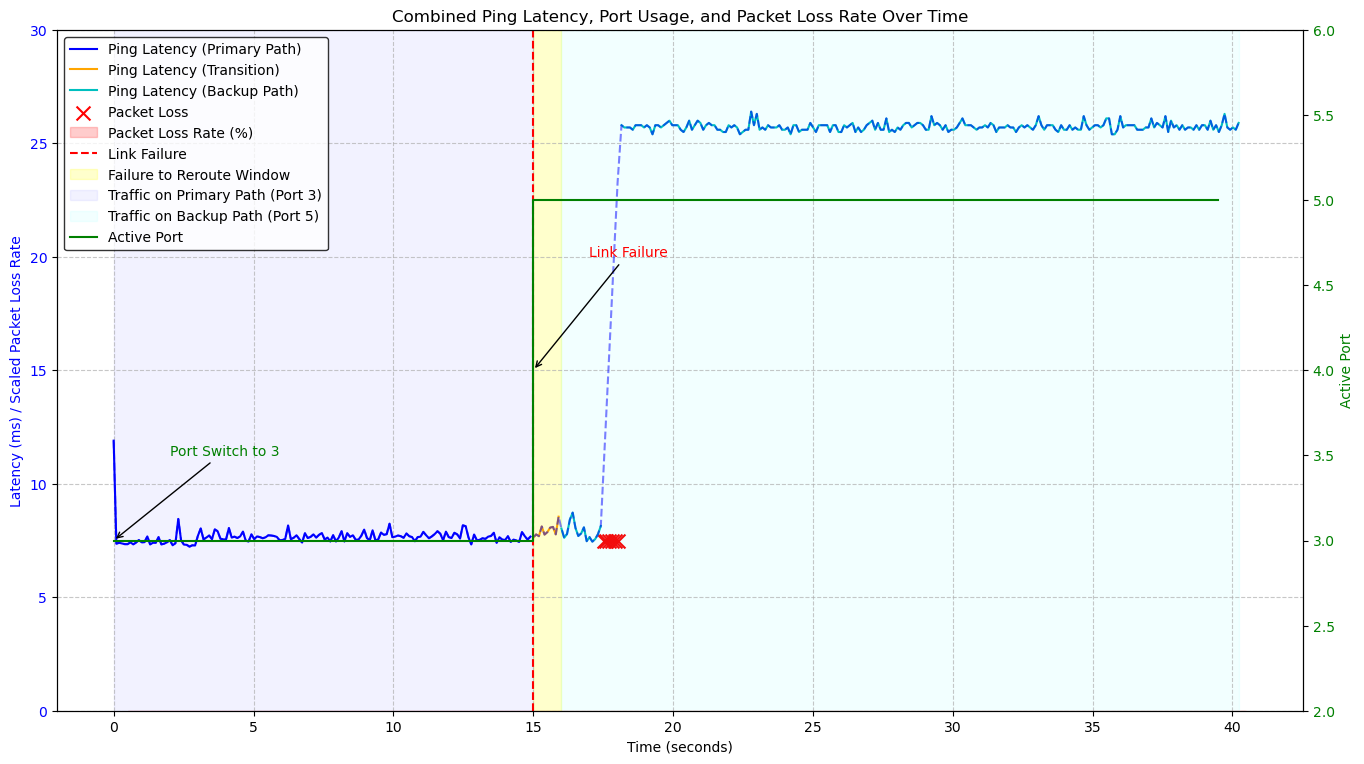

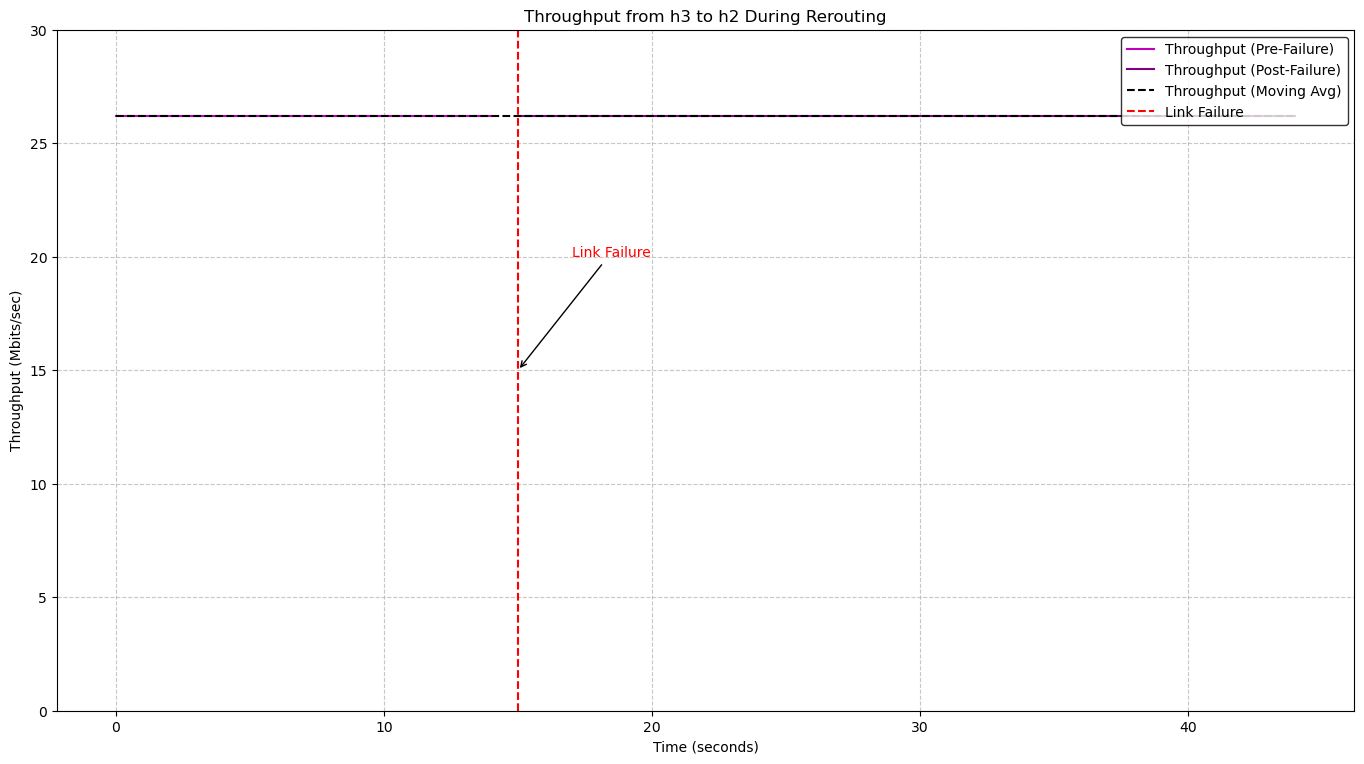

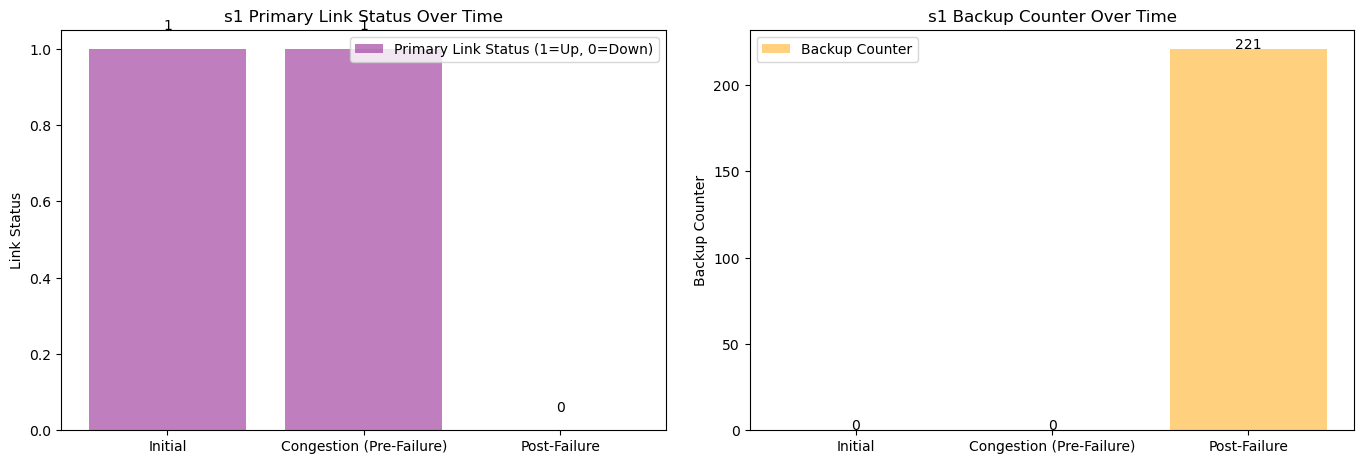

NameError: name 'cumulative_timestamps' is not defined

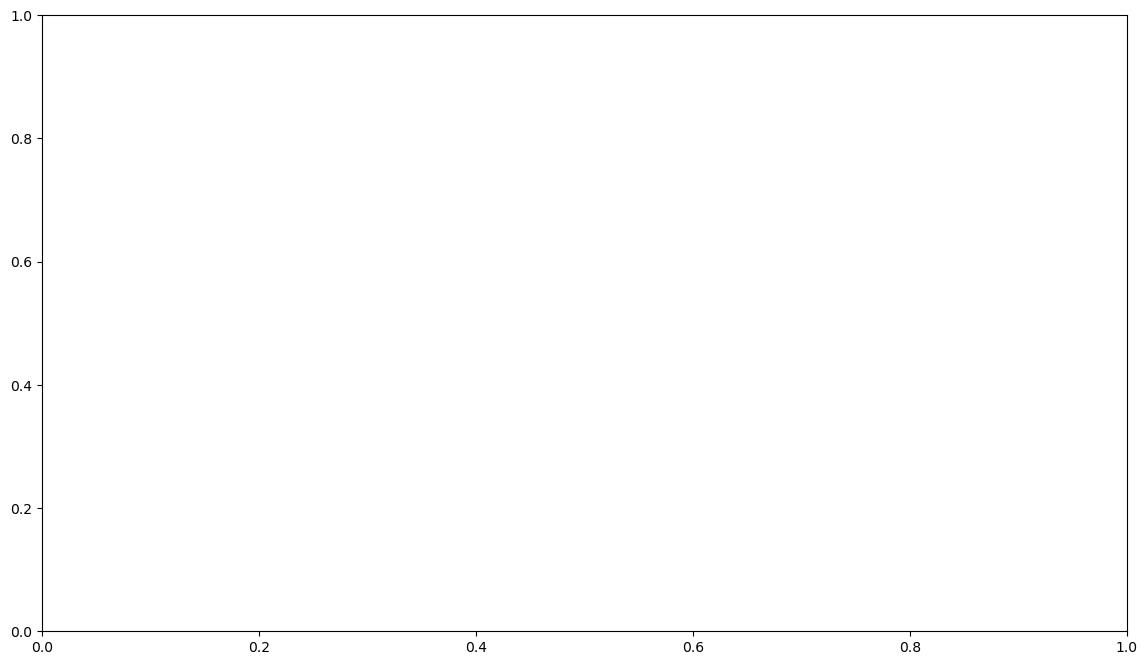

In [2]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np

# Parse ping log (already fixed to correctly detect packet loss)
def parse_ping_log(file_path):
    timestamps, seqs, times = [], [], []
    try:
        with open(file_path, 'r') as f:
            lines = f.readlines()
            expected_seq = 1
            for line in lines:
                if 'bytes from' in line:
                    timestamp = float(re.search(r'\[(.*?)\]', line).group(1))
                    seq = int(re.search(r'icmp_seq=(\d+)', line).group(1))
                    time = float(re.search(r'time=(\d+\.\d+)', line).group(1))
                    while expected_seq < seq:
                        if timestamps:
                            last_timestamp = timestamps[-1]
                            estimated_timestamp = last_timestamp + 0.1 * (expected_seq - seqs[-1])
                        else:
                            estimated_timestamp = timestamp
                        timestamps.append(estimated_timestamp)
                        seqs.append(expected_seq)
                        times.append(None)
                        expected_seq += 1
                    timestamps.append(timestamp)
                    seqs.append(seq)
                    times.append(time)
                    expected_seq = seq + 1
                elif 'timeout' in line or 'unreachable' in line:
                    timestamp = float(re.search(r'\[(.*?)\]', line).group(1))
                    seq = int(re.search(r'icmp_seq=(\d+)', line).group(1))
                    while expected_seq < seq:
                        last_timestamp = timestamps[-1] if timestamps else timestamp
                        estimated_timestamp = last_timestamp + 0.1 * (expected_seq - seqs[-1]) if seqs else timestamp
                        timestamps.append(estimated_timestamp)
                        seqs.append(expected_seq)
                        times.append(None)
                        expected_seq += 1
                    timestamps.append(timestamp)
                    seqs.append(seq)
                    times.append(None)
                    expected_seq = seq + 1
        if not timestamps:
            raise ValueError("No valid ping data found in the log file.")
        timestamps = [t - timestamps[0] for t in timestamps]
    except FileNotFoundError:
        print(f"Error: {file_path} not found. Using dummy ping data.")
        timestamps = list(range(0, 40, 1))
        seqs = list(range(1, 41))
        times = [7.5 if t < 15 else 25.0 for t in timestamps]
    return pd.DataFrame({'timestamp': timestamps, 'seq': seqs, 'time_ms': times})

# Parse register file (unchanged)
def parse_registers(file_path):
    link_status, backup_counter, h1_to_h2_active_port = None, None, None
    try:
        with open(file_path, 'r') as f:
            for line in f:
                if 'link_status=' in line:
                    link_status = [int(x) for x in line.split('=')[1].split(',')][:7]
                if 'backup_counter=' in line:
                    backup_counter = int(line.split('=')[1].strip())
                if 'h1_to_h2_active_port=' in line:
                    h1_to_h2_active_port = int(line.split('=')[1].strip())
        if link_status is None or backup_counter is None:
            raise ValueError(f"Missing required register data in {file_path}.")
        if h1_to_h2_active_port is None:
            print(f"Warning: h1_to_h2_active_port not found in {file_path}. Defaulting to 0.")
            h1_to_h2_active_port = 0
    except FileNotFoundError:
        print(f"Error: {file_path} not found. Using dummy register data.")
        link_status = [0, 0, 1, 1, 1, 1, 1]
        backup_counter = 0
        h1_to_h2_active_port = 0
    return {
        'link_status': link_status,
        'backup_counter': backup_counter,
        'h1_to_h2_active_port': h1_to_h2_active_port
    }

# Parse periodic register logs (0.5-second intervals)
def parse_periodic_registers(base_filename, num_logs=80):
    timestamps = []
    active_ports = []
    for i in range(num_logs):
        timestamp = i * 0.5
        file_path = f"{base_filename}_t{timestamp}.txt"
        try:
            with open(file_path, 'r') as f:
                for line in f:
                    if 'h1_to_h2_active_port=' in line:
                        active_port = int(line.split('=')[1].strip())
                        timestamps.append(timestamp)
                        active_ports.append(active_port)
                        break
                else:
                    print(f"Warning: h1_to_h2_active_port not found in {file_path}. Skipping.")
        except FileNotFoundError:
            print(f"Warning: {file_path} not found. Skipping.")
    if not timestamps:
        print("Error: No periodic register data found. Using dummy data.")
        timestamps = list(np.arange(0, 40, 0.5))
        active_ports = [3 if t < 15 else 5 for t in timestamps]
    return pd.DataFrame({'timestamp': timestamps, 'active_port': active_ports})

# Parse iperf log for throughput (unchanged)
def parse_iperf_log(file_path):
    throughput_data = {'timestamp': [], 'throughput': []}
    try:
        with open(file_path, 'r') as f:
            content = f.read()
            print(f"Raw iperf log content:\n{content}")
            for line in content.splitlines():
                match = re.search(r'\[\s*\d+\]\s*(\d+\.\d+-\d+\.\d+)\s+sec\s+\d+\.\d+\s+MBytes\s+(\d+\.\d+)\s+Mbits/sec', line)
                if match:
                    start_time = float(match.group(1).split('-')[0])
                    throughput_val = float(match.group(2))
                    throughput_data['timestamp'].append(start_time)
                    throughput_data['throughput'].append(throughput_val)
                else:
                    match_alt = re.search(r'(\d+\.\d+)\s+Mbits/sec', line)
                    if match_alt:
                        throughput_data['throughput'].append(float(match_alt.group(1)))
                        throughput_data['timestamp'].append(len(throughput_data['timestamp']) * 1.0)
        if not throughput_data['throughput']:
            print("No throughput data found in log. Using dummy data for debugging.")
            throughput_data['timestamp'] = [0, 5, 10, 15, 20, 25, 30]
            throughput_data['throughput'] = [25, 24, 23, 15, 14, 13, 12]
    except FileNotFoundError:
        print(f"Error: {file_path} not found. Using dummy data.")
        throughput_data['timestamp'] = [0, 5, 10, 15, 20, 25, 30]
        throughput_data['throughput'] = [25, 24, 23, 15, 14, 13, 12]
    return pd.DataFrame(throughput_data)

# Calculate packet loss rate over time
def calculate_packet_loss_rate(ping_data, window_size=1.0):
    ping_data = ping_data.sort_values('seq')
    timestamps = ping_data['timestamp'].values
    seqs = ping_data['seq'].values
    times = ping_data['time_ms'].values

    expected_seqs = np.arange(seqs[0], seqs[-1] + 1)
    actual_seqs = set(seqs)
    missing_seqs = [seq for seq in expected_seqs if seq not in actual_seqs]

    loss_timestamps = []
    for missing_seq in missing_seqs:
        before_idx = np.where(seqs < missing_seq)[0][-1] if np.any(seqs < missing_seq) else None
        after_idx = np.where(seqs > missing_seq)[0][0] if np.any(seqs > missing_seq) else None
        if before_idx is not None and after_idx is not None:
            t_before = timestamps[before_idx]
            t_after = timestamps[after_idx]
            s_before = seqs[before_idx]
            s_after = seqs[after_idx]
            t_missing = t_before + (t_after - t_before) * (missing_seq - s_before) / (s_after - s_before)
            loss_timestamps.append(t_missing)
        elif before_idx is not None:
            t_before = timestamps[before_idx]
            loss_timestamps.append(t_before + 0.1)
        elif after_idx is not None:
            t_after = timestamps[after_idx]
            loss_timestamps.append(t_after - 0.1)

    max_time = timestamps[-1]
    bins = np.arange(0, max_time + window_size, window_size)
    sent_counts, _ = np.histogram(timestamps, bins=bins)
    loss_counts, _ = np.histogram(loss_timestamps, bins=bins)
    bin_centers = (bins[:-1] + bins[1:]) / 2

    total_packets = sent_counts + loss_counts
    loss_rates = np.where(total_packets > 0, loss_counts / total_packets, 0) * 100
    return bin_centers, loss_rates, sent_counts, loss_counts

# Load data
ping_data = parse_ping_log('h1_ping.log')
s1_initial = parse_registers('s1_initial_regs.txt')
s1_congestion = parse_registers('s1_congestion_pre_failure.txt')
s1_post = parse_registers('s1_post_regs.txt')
periodic_data = parse_periodic_registers('s1_periodic', num_logs=80)
iperf_data = parse_iperf_log('h3_iperf_client.log')

# Failure time and reroute time
failure_time = 15.0
reroute_time = 16.0  # Based on the packet loss rate spike ending at 16 seconds

# Calculate packet loss rate
window_size = 1.0
loss_timestamps, loss_rates, sent_counts, loss_counts = calculate_packet_loss_rate(ping_data, window_size)

# 1. Combined Latency, Port Usage, and Packet Loss Rate Plot
fig, ax1 = plt.subplots(figsize=(14, 8))

# Latency Plot with traffic flow indication (left y-axis)
pre_failure = ping_data[ping_data['timestamp'] < failure_time]
transition = ping_data[(ping_data['timestamp'] >= failure_time) & (ping_data['timestamp'] < reroute_time)]
post_failure = ping_data[ping_data['timestamp'] >= reroute_time]
ax1.plot(pre_failure['timestamp'], pre_failure['time_ms'], 'b-', label='Ping Latency (Primary Path)', linewidth=1.5)
ax1.plot(transition['timestamp'], transition['time_ms'], 'orange', label='Ping Latency (Transition)', linewidth=1.5)
ax1.plot(post_failure['timestamp'], post_failure['time_ms'], 'c-', label='Ping Latency (Backup Path)', linewidth=1.5)
ping_data['time_ms_smooth'] = ping_data['time_ms'].interpolate(method='linear')
ax1.plot(ping_data['timestamp'], ping_data['time_ms_smooth'], 'b--', alpha=0.5)

# Packet Loss Markers
loss_points = ping_data[ping_data['time_ms'].isna()]
if not loss_points.empty:
    ax1.scatter(loss_points['timestamp'], [7.5] * len(loss_points), color='red', marker='x', s=100, label='Packet Loss')
else:
    ax1.text(failure_time + 1, 5, 'No Packet Loss Observed', color='red', fontsize=10, bbox=dict(facecolor='white', alpha=0.8))

# Packet Loss Rate (left y-axis, scaled to fit with latency)
# Scale the packet loss rate to fit within the latency range (0–30 ms)
scaled_loss_rates = loss_rates * (30 / 100)  # Scale 0–100% to 0–30 ms range
ax1.fill_between(loss_timestamps, 0, scaled_loss_rates, color='red', alpha=0.2, label='Packet Loss Rate (%)')

ax1.set_ylabel('Latency (ms) / Scaled Packet Loss Rate', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.set_title('Combined Ping Latency, Port Usage, and Packet Loss Rate Over Time')
ax1.grid(True, linestyle='--', alpha=0.7)
ax1.set_ylim(0, 30)
ax1.axvline(failure_time, color='r', linestyle='--', label='Link Failure')
ax1.annotate('Link Failure', xy=(failure_time, 15), xytext=(failure_time + 2, 20),
             arrowprops=dict(arrowstyle='->'), color='r')

# Highlight the transition window
ax1.axvspan(failure_time, reroute_time, color='yellow', alpha=0.2, label='Failure to Reroute Window')

# Add shaded regions for traffic flow
ax1.axvspan(0, failure_time, color='blue', alpha=0.05, label='Traffic on Primary Path (Port 3)')
ax1.axvspan(reroute_time, ping_data['timestamp'].max(), color='cyan', alpha=0.05, label='Traffic on Backup Path (Port 5)')

# Active Port Plot (right y-axis)
ax2 = ax1.twinx()
ax2.step(periodic_data['timestamp'], periodic_data['active_port'], 'g-', where='post', label='Active Port', linewidth=1.5)
ax2.set_ylabel('Active Port', color='g')
ax2.tick_params(axis='y', labelcolor='g')
ax2.set_ylim(2, 6)

# Annotate the port switch
switch_idx = periodic_data['active_port'].ne(periodic_data['active_port'].shift()).idxmax()
switch_time = periodic_data['timestamp'].iloc[switch_idx] if switch_idx < len(periodic_data) else failure_time
switch_port = periodic_data['active_port'].iloc[switch_idx] if switch_idx < len(periodic_data) else 5
ax2.annotate(f'Port Switch to {switch_port}', xy=(switch_time, switch_port), xytext=(switch_time + 2, switch_port + 0.5),
             arrowprops=dict(arrowstyle='->'), color='g')

# Combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', frameon=True, edgecolor='black', fontsize=10)

ax1.set_xlabel('Time (seconds)')
plt.tight_layout(pad=2.0)
plt.savefig('combined_rerouting_plot.png')
plt.show()

# 2. Throughput Plot with Moving Average (unchanged)
fig, ax = plt.subplots(figsize=(14, 8))
if not iperf_data.empty and 'timestamp' in iperf_data.columns and 'throughput' in iperf_data.columns:
    pre_failure_iperf = iperf_data[iperf_data['timestamp'] < failure_time]
    post_failure_iperf = iperf_data[iperf_data['timestamp'] >= failure_time]
    ax.plot(pre_failure_iperf['timestamp'], pre_failure_iperf['throughput'], 'm-', label='Throughput (Pre-Failure)', linewidth=1.5)
    ax.plot(post_failure_iperf['timestamp'], post_failure_iperf['throughput'], 'purple', label='Throughput (Post-Failure)', linewidth=1.5)
    iperf_data['throughput_ma'] = iperf_data['throughput'].rolling(window=3, min_periods=1).mean()
    ax.plot(iperf_data['timestamp'], iperf_data['throughput_ma'], 'k--', label='Throughput (Moving Avg)', linewidth=1.5)
else:
    print("Warning: No valid iperf data to plot. Skipping throughput plot.")
ax.axvline(failure_time, color='r', linestyle='--', label='Link Failure')
ax.annotate('Link Failure', xy=(failure_time, 15), xytext=(failure_time + 2, 20),
            arrowprops=dict(arrowstyle='->'), color='r')
ax.set_xlabel('Time (seconds)')
ax.set_ylabel('Throughput (Mbits/sec)')
ax.tick_params(axis='y')
ax.set_title('Throughput from h3 to h2 During Rerouting')
ax.grid(True, linestyle='--', alpha=0.7)
ax.set_ylim(0, 30)
ax.legend(loc='upper right', frameon=True, edgecolor='black', fontsize=10)
plt.tight_layout(pad=2.0)
plt.savefig('throughput_plot.png')
plt.show()

# 3. Enhanced Register Plot with Link Status and Backup Counter (unchanged)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
stages = ['Initial', 'Congestion (Pre-Failure)', 'Post-Failure']
link_status_s1 = [s1_initial['link_status'][3], s1_congestion['link_status'][3], s1_post['link_status'][3]]
backup_counters = [s1_initial['backup_counter'], s1_congestion['backup_counter'], s1_post['backup_counter']]

ax1.bar(stages, link_status_s1, color='purple', alpha=0.5, label='Primary Link Status (1=Up, 0=Down)')
ax1.set_xticks(range(len(stages)))
ax1.set_xticklabels(stages)
ax1.set_ylabel('Link Status')
ax1.set_title('s1 Primary Link Status Over Time')
ax1.legend()
for i, v in enumerate(link_status_s1):
    ax1.text(i, v + 0.05, str(v), ha='center', fontsize=10)

ax2.bar(stages, backup_counters, color='orange', alpha=0.5, label='Backup Counter')
ax2.set_xticks(range(len(stages)))
ax2.set_xticklabels(stages)
ax2.set_ylabel('Backup Counter')
ax2.set_title('s1 Backup Counter Over Time')
ax2.legend()
for i, v in enumerate(backup_counters):
    ax2.text(i, v + 0.5, str(v), ha='center', fontsize=10)

plt.tight_layout(pad=2.0)
plt.savefig('register_states_enhanced.png')
plt.show()

# 4. Cumulative Packet Loss Plot (unchanged)
fig, ax = plt.subplots(figsize=(14, 8))
ax.plot(cumulative_timestamps, cumulative_loss, 'r-', label='Cumulative Packet Loss', linewidth=1.5)
ax.set_xlabel('Time (seconds)')
ax.set_ylabel('Cumulative Packet Loss (Packets)', color='r')
ax.tick_params(axis='y', labelcolor='r')
ax.set_title('Cumulative Packet Loss Over Time')
ax.grid(True, linestyle='--', alpha=0.7)
ax.axvline(failure_time, color='r', linestyle='--', label='Link Failure')
ax.annotate('Link Failure', xy=(failure_time, cumulative_loss[-1] / 2), xytext=(failure_time + 2, cumulative_loss[-1] / 2 + 1),
            arrowprops=dict(arrowstyle='->'), color='r')
ax.axvspan(failure_time, reroute_time, color='yellow', alpha=0.2, label='Failure to Reroute Window')
ax.legend(loc='upper left', frameon=True, edgecolor='black', fontsize=10)
plt.tight_layout(pad=2.0)
plt.savefig('cumulative_packet_loss_plot.png')
plt.show()